# **Individual Assignment – Fixed Income Portfolio Analysis**

---

**Student:** Lorenzo Gumiero – s4152225  
**Course Code:** BAFI1065  
**Course Title:** Fixed Income Securities and Credit Analysis  
**University:** RMIT University  
**Term:** Semester 1, 2025

---

# Part 2 – Portfolio Analysis (80 Marks)

This section of the assignment involves a comprehensive evaluation of an assigned fixed income portfolio comprising six Australian government or corporate bonds and a benchmark bond index. Portfolio allocations and benchmark assignments are provided in the document titled *"Australian bond list – public_2025S1.pdf"*. Pages 1–3 detail the student-specific allocations and weights, while pages 4–7 include descriptions and identifiers for all available securities.

Students are required to retrieve relevant bond data using LSEG Workspace (Refinitiv), based on the identifiers supplied. In cases where a specific bond’s data is unavailable, an alternative bond from the provided list may be substituted. Any substitutions must be clearly documented in the introduction.

---

## Task A

Calculate the **annualized tracking error** of your assigned bond portfolio relative to the benchmark index, using **daily return data over a one-year period**. Clearly present your results and provide a concise but insightful discussion on the degree to which the portfolio replicates the benchmark’s performance. Interpret the tracking error in the context of portfolio management and fixed income replicati

----



### **Portfolio Structure Definition**

This subsection defines the assigned portfolio using the allocation provided in the official assignment document ("Australian bond list – public_2025S1.pdf"). The portfolio contains six Australian bonds, each with an associated weight, issuer, and name. From the bond name, we extract both the coupon rate and the maturity date, which will be used in later analysis such as duration-based immunisation. The benchmark index is the iShares Australian Bond Index (RIC: P63511336).



In [ ]:
# --- Define portfolio structure manually from assignment document ---
import pandas as pd
import re

portfolio_data = {
    "Bond Code": [10, 11, 37, 50, 12, 9],
    "RIC/ISIN": ["XS2223749958", "AU3CB0235281", "AU3CB0298487", "AUG02500530=", "XS2436881671", "XS1694223386"],
    "Issuer": ["Commonwealth Bank", "Macquarie Group", "Worley Financial Services PTY LTD",
               "Australian Gov Bond", "Macquarie Group", "Commonwealth Bank"],
    "Bond Name": [
        "CBA 3.300 26-AUG-2050",
        "MQG 4.250 28-JUL-2026 MTN",
        "WORX 5.950 13-OCT-2028 '28 MTN",
        "AUGV 2.500 21-MAY-2030",
        "MQG 3.100 27-JAN-2032 MTN",
        "CBA 4.485 11-OCT-2047"
    ],
    "Weight": [0.22, 0.09, 0.16, 0.12, 0.16, 0.25]
}

# --- Create DataFrame ---
df_portfolio = pd.DataFrame(portfolio_data)

# --- Extract coupon and maturity ---
def extract_coupon(bond_name):
    match = re.search(r"\d{1,2}\.\d{3}", bond_name)
    return float(match.group()) if match else None

def extract_maturity(bond_name):
    match = re.search(r"\d{2}-[A-Z]{3}-\d{4}", bond_name)
    return pd.to_datetime(match.group(), format="%d-%b-%Y") if match else None

df_portfolio["Coupon (%)"] = df_portfolio["Bond Name"].apply(extract_coupon)
df_portfolio["Maturity Date"] = df_portfolio["Bond Name"].apply(extract_maturity)

# --- Extract short name (first group of letters) ---
def extract_shortname(bond_name):
    match = re.match(r"([A-Z]+)", bond_name)
    return match.group(1) if match else "UNKNOWN"

df_portfolio["Short Name"] = df_portfolio["Bond Name"].apply(extract_shortname)
df_portfolio["Maturity Year"] = df_portfolio["Maturity Date"].dt.year.astype(str)

# --- Create Refinitiv-aligned data label ---
df_portfolio["Data Label"] = df_portfolio["Bond Code"].astype(str) + "_" + df_portfolio["Short Name"] + "_" + df_portfolio["Maturity Year"]

# --- Benchmark Info ---
benchmark_info = {
    "Benchmark Name": "iShares Australian Bond Index",
    "Benchmark RIC": "LP63511336"
}

# --- Display outputs ---
print("Assigned Bond Portfolio:")
display(df_portfolio)
print("\nBenchmark Info:")
print(benchmark_info)


Assigned Bond Portfolio:


,Bond Code,RIC/ISIN,Issuer,Bond Name,Weight,Coupon (%),Maturity Date,Short Name,Maturity Year,Data Label
0,10,XS2223749958,Commonwealth Bank,CBA 3.300 26-AUG-2050,0.22,3.300,2050-08-26,CBA,2050,10_CBA_2050
1,11,AU3CB0235281,Macquarie Group,MQG 4.250 28-JUL-2026 MTN,0.09,4.250,2026-07-28,MQG,2026,11_MQG_2026
2,37,AU3CB0298487,Worley Financial Services PTY LTD,WORX 5.950 13-OCT-2028 '28 MTN,0.16,5.950,2028-10-13,WORX,2028,37_WORX_2028
3,50,AUG02500530=,Australian Gov Bond,AUGV 2.500 21-MAY-2030,0.12,2.500,2030-05-21,AUGV,2030,50_AUGV_2030
4,12,XS2436881671,Macquarie Group,MQG 3.100 27-JAN-2032 MTN,0.16,3.100,2032-01-27,MQG,2032,12_MQG_2032
5,9,XS1694223386,Commonwealth Bank,CBA 4.485 11-OCT-2047,0.25,4.485,2047-10-11,CBA,2047,9_CBA_2047



Benchmark Info:
{'Benchmark Name': 'iShares Australian Bond Index', 'Benchmark RIC': 'LP63511336'}


### **Refinitiv Data Import**

In this subsection, we import the daily data extracted from Refinitiv Workspace for each of the six assigned bonds. Each Excel file contains time series of daily Bid, Ask, and Yield to Maturity values. These variables will later be used to compute mid prices and return series. At this stage, no data cleaning or transformation is applied; missing values (NaNs) are preserved to maintain full structural integrity for further analysis.


In [ ]:
# --- Import libraries ---
import pandas as pd

# --- Define the file paths (6 bonds + 1 benchmark) ---
file_paths = {
    "10_CBA_2050": "Bond1_x10.xlsx",
    "11_MQG_2026": "Bond2_x11.xlsx",
    "37_WORX_2028": "Bond3_x37.xlsx",
    "50_AUGV_2030": "Bond4_x50.xlsx",
    "12_MQG_2032": "Bond5_x12.xlsx",
    "9_CBA_2047":  "Bond6_x9.xlsx",
    "00_BENCHMARK": "Refinitiv_benchmark.xlsx"  # Benchmark treated as a bond
}

# --- Load each file into a separate DataFrame and store in dictionary ---
bond_dfs = {}
for label, path in file_paths.items():
    df = pd.read_excel(path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")
    df = df[~df.index.duplicated(keep="first")]  # Remove any duplicate dates
    bond_dfs[label] = df

# --- Unpack if needed (bond examples) ---
df_10_CBA_2050 = bond_dfs["10_CBA_2050"]
df_11_MQG_2026 = bond_dfs["11_MQG_2026"]
df_37_WORX_2028 = bond_dfs["37_WORX_2028"]
df_50_AUGV_2030 = bond_dfs["50_AUGV_2030"]
df_12_MQG_2032 = bond_dfs["12_MQG_2032"]
df_9_CBA_2047  = bond_dfs["9_CBA_2047"]
df_benchmark   = bond_dfs["00_BENCHMARK"]

# --- Optional: print confirmation ---
print("Imported all bond and benchmark data into `bond_dfs`")
print("DataFrames:", list(bond_dfs.keys()))

# --- Preview example bond and benchmark ---
display(df_10_CBA_2050.head())
display(df_benchmark.head())



Imported all bond and benchmark data into `bond_dfs`
DataFrames: ['10_CBA_2050', '11_MQG_2026', '37_WORX_2028', '50_AUGV_2030', '12_MQG_2032', '9_CBA_2047', '00_BENCHMARK']


,Bid Price,Ask Price,Yield to Maturity,Accrued Interest,Macaulay Duration
Date,,,,,
2024-01-01,53.843,54.214,7.26,1.16417,NaN
2024-01-02,53.973,54.345,7.24,1.17333,NaN
2024-01-03,54.197,54.571,7.21,1.18250,NaN
2024-01-04,54.027,54.400,7.24,1.21000,NaN
2024-01-05,53.582,53.950,7.30,1.21917,NaN


,Bid Price,Ask Price,Yield to Maturity,Accrued Interest,Macaulay Duration
Date,,,,,
2023-12-29,0.931562,0.932358,NaN,NaN,NaN
2024-01-02,0.930050,0.930980,NaN,NaN,NaN
2024-01-03,0.927515,0.928443,NaN,NaN,NaN
2024-01-04,0.927275,0.928203,NaN,NaN,NaN
2024-01-05,0.923746,0.924670,NaN,NaN,NaN


### **Cleaning and Mid Price Calculation**

To ensure consistent portfolio return estimation, we begin by computing the daily *mid prices* for each of the six assigned bonds and the benchmark index.

For each security:
- We remove all rows with missing values in either the **Bid Price** or **Ask Price** columns.
- Then, we calculate the **Mid Price** as:

    Mid Price = (Bid Price + Ask Price) / 2

Once mid prices are computed for all instruments, we identify the set of **common dates** across all DataFrames. This alignment ensures that all return and risk metrics are computed on the same timeline.

The final output is a clean, aligned DataFrame (`df_midprice_all`) containing mid prices for all six bonds and the benchmark. This dataset will be used in the next step to compute daily returns and evaluate tracking error.



In [ ]:
# --- Step 1: Clean individual bond DataFrames and compute Mid Price ---
mid_price_dfs = {}

for label, df in bond_dfs.items():
    # Check required columns exist
    if "Bid Price" in df.columns and "Ask Price" in df.columns:
        df_clean = df.dropna(subset=["Bid Price", "Ask Price"]).copy()
        df_clean["Mid Price"] = (df_clean["Bid Price"] + df_clean["Ask Price"]) / 2
        mid_price_dfs[label] = df_clean[["Mid Price"]]
    else:
        raise ValueError(f"Missing required columns in: {label}")

# --- Step 2: Find common dates across all cleaned DataFrames ---
common_dates = set.intersection(*(set(df.index) for df in mid_price_dfs.values()))

# --- Step 3: Align all Mid Prices on common dates and combine into one DataFrame ---
mid_price_aligned = {
    label: df.loc[sorted(common_dates)] for label, df in mid_price_dfs.items()
}

df_midprice_all = pd.concat(mid_price_aligned.values(), axis=1, keys=mid_price_aligned.keys())

# --- Optional: Rename columns to flatten MultiIndex ---
df_midprice_all.columns = [f"{label}_Mid" for label in mid_price_aligned.keys()]

# --- Preview final aligned Mid Price DataFrame ---
print("Mid Price Portfolio Matrix (aligned):")
display(df_midprice_all.head())



Mid Price Portfolio Matrix (aligned):


,10_CBA_2050_Mid,11_MQG_2026_Mid,37_WORX_2028_Mid,50_AUGV_2030_Mid,12_MQG_2032_Mid,9_CBA_2047_Mid,00_BENCHMARK_Mid
Date,,,,,,,
2024-01-02,54.1590,98.8020,101.4495,92.6655,85.2010,54.1590,0.930515
2024-01-03,54.3840,98.6755,101.3025,92.4825,85.1680,54.3840,0.927979
2024-01-04,54.2135,98.6550,101.4520,92.5555,84.6920,54.2135,0.927739
2024-01-05,53.7660,98.4960,101.0090,92.1515,84.3975,53.7660,0.924208
2024-01-08,54.6165,98.2985,100.8040,91.8570,84.4565,54.6165,0.922930


### **Daily Return Calculation and Annualised Tracking Error**

To evaluate the degree of alignment between the assigned bond portfolio and the benchmark index, daily log returns are computed for each instrument using the cleaned mid price series.

The daily return is calculated using the following formula:

    Return_t = ln(P_t / P_{t-1})

where *P_t* represents the mid price at time *t*. Based on these return series:

- The **portfolio return** is derived as the weighted average of individual bond returns, using the official allocation weights.
- The **tracking error series** is computed as the difference between the portfolio return and the benchmark return on each trading day.
- The **annualised tracking error** is obtained by calculating the standard deviation of the daily differences and scaling it by √252, which reflects the typical number of trading days in a year.

The annualised tracking error quantifies the volatility of excess returns relative to the benchmark and serves as a key performance indicator for passive replication strategies in fixed income portfolio management.


In [ ]:
import numpy as np
import pandas as pd

# --- Step 1: Compute daily log returns for each instrument ---
log_returns = df_midprice_all.apply(lambda x: np.log(x / x.shift(1))).dropna()

# --- Step 2: Extract weights based on actual matching labels ---
columns_no_suffix = [col.replace("_Mid", "") for col in log_returns.columns if col != "00_BENCHMARK_Mid"]
weights_series = df_portfolio.set_index("Data Label").loc[columns_no_suffix, "Weight"]
weights = weights_series.values

# --- Step 3: Compute weighted portfolio return ---
portfolio_returns = log_returns.iloc[:, :-1].dot(weights)

# --- Step 4: Extract benchmark return ---
benchmark_returns = log_returns.iloc[:, -1]

# --- Step 5: Compute tracking error series ---
tracking_diff = portfolio_returns - benchmark_returns

# --- Step 6: Compute standard deviation and annualise it ---
tracking_error_daily = tracking_diff.std()
tracking_error_annualised = tracking_error_daily * np.sqrt(252)

# --- Step 7: Summarise in tabular format ---
df_tracking_error = pd.DataFrame({
    "Metric": ["Daily Tracking Error", "Annualised Tracking Error"],
    "Value (Decimal)": [tracking_error_daily, tracking_error_annualised],
    "Value (bps)": [round(tracking_error_daily * 10000, 2),
                    round(tracking_error_annualised * 10000, 2)]
})

# --- Display output ---
display(df_tracking_error)



,Metric,Value (Decimal),Value (bps)
0,Daily Tracking Error,0.004983,49.83
1,Annualised Tracking Error,0.079109,791.09


### **Visual Analysis of Tracking Error and Relative Performance**

To complement the numerical estimate of the tracking error, two graphical representations are provided to illustrate the performance dynamics between the constructed portfolio and the benchmark index.

The first plot presents the **cumulative log performance** of both the portfolio and the benchmark over the analysis period, starting from a common initial value of $10,000. This representation helps to visualise not only the relative trajectory of both return series, but also periods of **outperformance** (shaded in green) and **underperformance** (shaded in red) of the portfolio with respect to the benchmark.

The second plot shows the **distribution of daily tracking errors**. By displaying the frequency and dispersion of the tracking error series, this histogram allows for an assessment of how tightly the portfolio tracks the benchmark on a day-to-day basis. The mean of the tracking error is marked with a vertical line, helping to identify any consistent bias in performance deviation.

Together, these visual tools provide a more comprehensive understanding of the nature, timing, and volatility of the portfolio's deviation from its benchmark—insights that complement the numerical tracking error and enhance the overall interpretability of the portfolio’s replication quality.


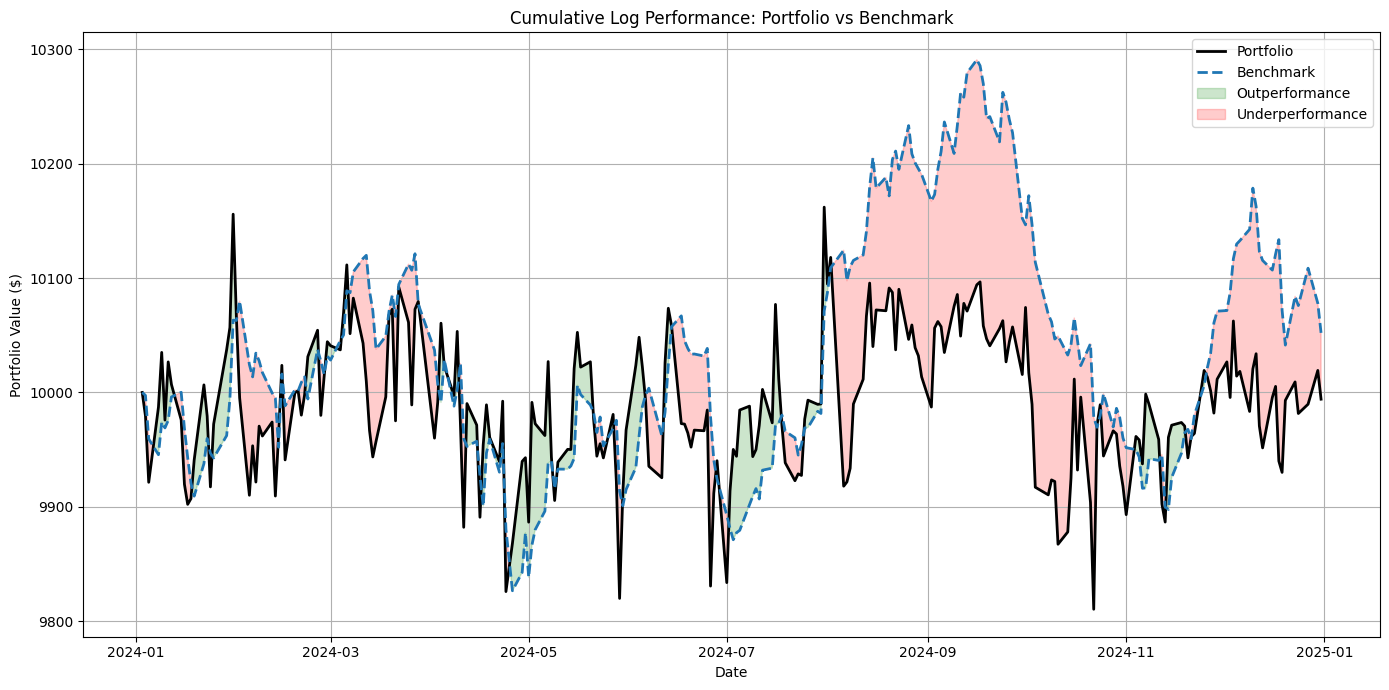

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Align returns and drop missing values
aligned_returns = pd.DataFrame({
    "Portfolio": portfolio_returns,
    "Benchmark": benchmark_returns
}).dropna()

# Set initial value
initial_value = 10000

# Force both series to start at same value
portfolio_log_cum = np.cumsum(aligned_returns["Portfolio"])
benchmark_log_cum = np.cumsum(aligned_returns["Benchmark"])

portfolio_cum = initial_value * np.exp(portfolio_log_cum - portfolio_log_cum.iloc[0])
benchmark_cum = initial_value * np.exp(benchmark_log_cum - benchmark_log_cum.iloc[0])

# Combine in one DataFrame
aligned_cumulative = pd.DataFrame({
    "Portfolio": portfolio_cum,
    "Benchmark": benchmark_cum
}, index=aligned_returns.index)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(aligned_cumulative.index, aligned_cumulative["Portfolio"], label='Portfolio',color='black', linestyle='-', linewidth=2)
plt.plot(aligned_cumulative.index, aligned_cumulative["Benchmark"], label='Benchmark', linestyle='--', linewidth=2)

plt.fill_between(
    aligned_cumulative.index,
    aligned_cumulative["Portfolio"],
    aligned_cumulative["Benchmark"],
    where=(aligned_cumulative["Portfolio"] > aligned_cumulative["Benchmark"]),
    interpolate=True,
    color='green',
    alpha=0.2,
    label='Outperformance'
)

plt.fill_between(
    aligned_cumulative.index,
    aligned_cumulative["Portfolio"],
    aligned_cumulative["Benchmark"],
    where=(aligned_cumulative["Portfolio"] < aligned_cumulative["Benchmark"]),
    interpolate=True,
    color='red',
    alpha=0.2,
    label='Underperformance'
)

plt.title("Cumulative Log Performance: Portfolio vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


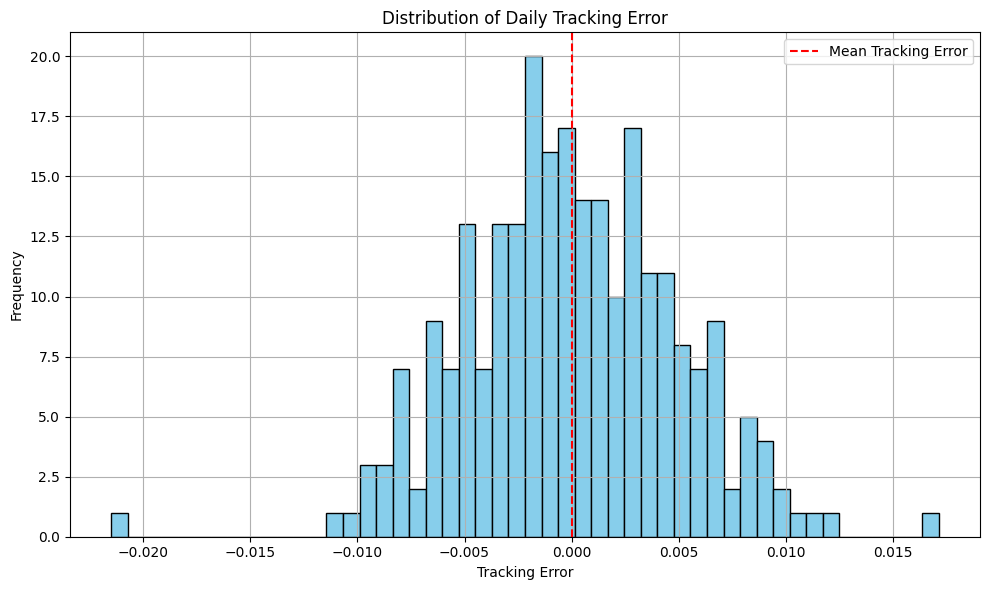

In [ ]:
# --- Plot 2: Distribution of daily tracking error ---
tracking_error_series = aligned_returns["Portfolio"] - aligned_returns["Benchmark"]

plt.figure(figsize=(10, 6))
plt.hist(tracking_error_series, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=tracking_error_series.mean(), color='red', linestyle='--', label='Mean Tracking Error')
plt.title("Distribution of Daily Tracking Error")
plt.xlabel("Tracking Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Report table**

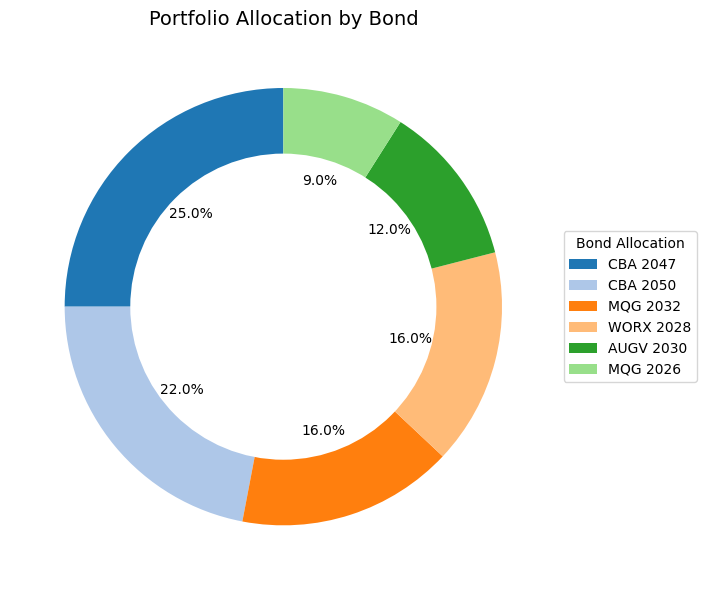

In [ ]:
import matplotlib.pyplot as plt

# Prepare labels and weights
labels = df_portfolio["Short Name"] + " " + df_portfolio["Maturity Year"]
weights = df_portfolio["Weight"]

# Optional: define custom colors
colors = plt.get_cmap('tab20').colors[:len(weights)]

# Sort by weight for cleaner display
sorted_idx = weights.argsort()[::-1]
labels_sorted = labels.iloc[sorted_idx]
weights_sorted = weights.iloc[sorted_idx]

# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(
    weights_sorted,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4),
    textprops=dict(color="black", fontsize=10)
)

# Add central circle for donut effect
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Add legend outside
ax.legend(
    wedges,
    labels_sorted,
    title="Bond Allocation",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

plt.title("Portfolio Allocation by Bond", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Create a copy excluding specified columns
df_portfolio_clean = df_portfolio.drop(columns=["RIC/ISIN", "Short Name", "Data Label"]).copy()

# Display the result
print("Cleaned Portfolio Table:")
display(df_portfolio_clean)


Cleaned Portfolio Table:


,Bond Code,Issuer,Bond Name,Weight,Coupon (%),Maturity Date,Maturity Year
0,10,Commonwealth Bank,CBA 3.300 26-AUG-2050,0.22,3.300,2050-08-26,2050
1,11,Macquarie Group,MQG 4.250 28-JUL-2026 MTN,0.09,4.250,2026-07-28,2026
2,37,Worley Financial Services PTY LTD,WORX 5.950 13-OCT-2028 '28 MTN,0.16,5.950,2028-10-13,2028
3,50,Australian Gov Bond,AUGV 2.500 21-MAY-2030,0.12,2.500,2030-05-21,2030
4,12,Macquarie Group,MQG 3.100 27-JAN-2032 MTN,0.16,3.100,2032-01-27,2032
5,9,Commonwealth Bank,CBA 4.485 11-OCT-2047,0.25,4.485,2047-10-11,2047


## **Task B**

Suppose your objective is to align your portfolio more closely with the benchmark index. First, consider how you would achieve this without altering the existing bond composition—what adjustments or strategies could you apply using only the current components? Then, address how you would approach this objective if you were allowed to change the portfolio's composition. Use the available data to support and justify your responses in both cases. (10 marks)

### **Issuer Composition – Portfolio vs Benchmark (with “Other”)**

This chart compares the macro‐issuer composition of the assigned portfolio against the benchmark index, grouped into four categories:

- **Sovereign**: National and state government issuers  
- **Major Bank**: Large financial institutions (CBA, MQG)  
- **Corporate**: Other private issuers (e.g. Worley)  
- **Other**: Supranationals and all remaining index holdings  

Including “Other” ensures the benchmark’s full 100% allocation is shown. The portfolio’s heavy tilt to Major Banks (72%) and light Sovereign weight (12%) versus the benchmark’s sovereign‐heavy mix (~77%) is a major driver of tracking error.



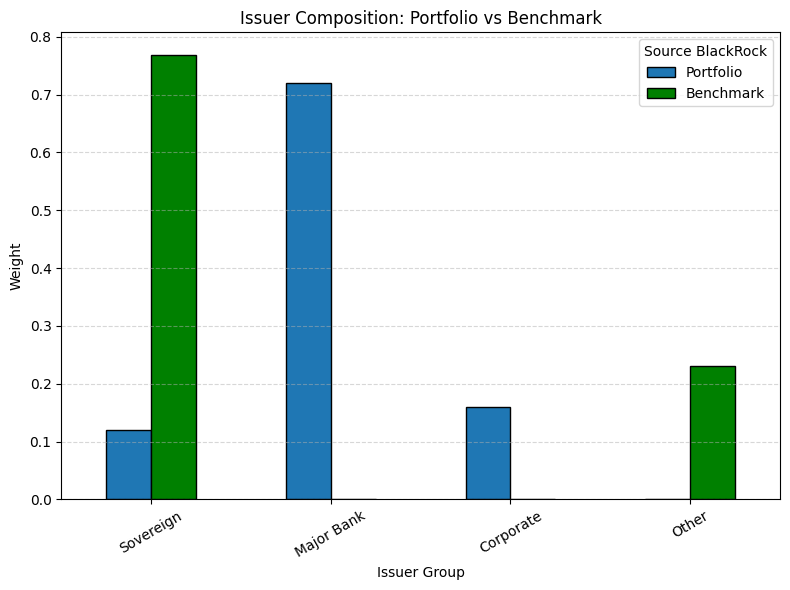

In [ ]:
# --- Section B.1: Issuer Composition Comparison on a Separate DataFrame (non-destructive) ---
import matplotlib.pyplot as plt
import pandas as pd

# 1) Make a lightweight copy for grouping, so df_portfolio remains intact
df_temp = df_portfolio[["Issuer", "Weight"]].copy()

# Map each bond to a macro group
issuer_group_map = {
    "Commonwealth Bank": "Major Bank",
    "Macquarie Group":    "Major Bank",
    "Worley Financial Services PTY LTD": "Corporate",
    "Australian Gov Bond": "Sovereign"
}
df_temp["Issuer Group"] = df_temp["Issuer"].map(issuer_group_map)

# Aggregate weights by group
portfolio_group_weights = (
    df_temp.groupby("Issuer Group")["Weight"]
    .sum()
)

# Ensure all four categories appear
portfolio_full = portfolio_group_weights.reindex(
    ["Sovereign", "Major Bank", "Corporate", "Other"], fill_value=0
)

# 2) Build benchmark group weights (from assignment brief)
top10 = {
    "AUSTRALIA (COMMONWEALTH OF)": 45.83,
    "TREASURY CORPORATION OF VICTORIA": 9.66,
    "NEW SOUTH WALES TREASURY CORPORATION": 9.21,
    "QUEENSLAND TREASURY CORPORATION": 7.25,
    "WESTERN AUSTRALIAN TREASURY CORPORATION": 2.27,
    "SOUTH AUSTRALIAN GOVERNMENT FINANCING AUTHORITY": 1.87,
    "AUSTRALIAN CAPITAL TERRITORY (GOVERNMENT OF)": 0.82
}
sovereign_w = sum(top10.values()) / 100
benchmark_full = pd.Series({
    "Sovereign": sovereign_w,
    "Major Bank": 0.0,
    "Corporate": 0.0,
    "Other": 1 - sovereign_w
})

# 3) Create a new DataFrame for qualitative assessment
df_qualitative_assessment = pd.DataFrame({
    "Portfolio": portfolio_full,
    "Benchmark": benchmark_full
})

# 4) Plot side-by-side bar chart
ax = df_qualitative_assessment.plot(
    kind="bar",
    figsize=(8, 6),
    color=["#1f77b4", "#008000"],  # blue for portfolio, green for benchmark
    edgecolor="black"
)
ax.set_title("Issuer Composition: Portfolio vs Benchmark")
ax.set_ylabel("Weight")
ax.set_xlabel("Issuer Group")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=30)
plt.legend(title="Source BlackRock")
plt.tight_layout()
plt.show()



### **Correlation Analysis of Daily Returns**

This subsection evaluates the return dynamics of individual bonds relative to the benchmark. Pairwise correlations are computed using the daily log return series to assess the strength of co-movement.

Higher correlations with the benchmark indicate better tracking potential, while weak or negative correlations highlight securities that contribute to tracking error.

The heatmap below presents the full correlation matrix, followed by individual scatterplots for each bond versus the benchmark.


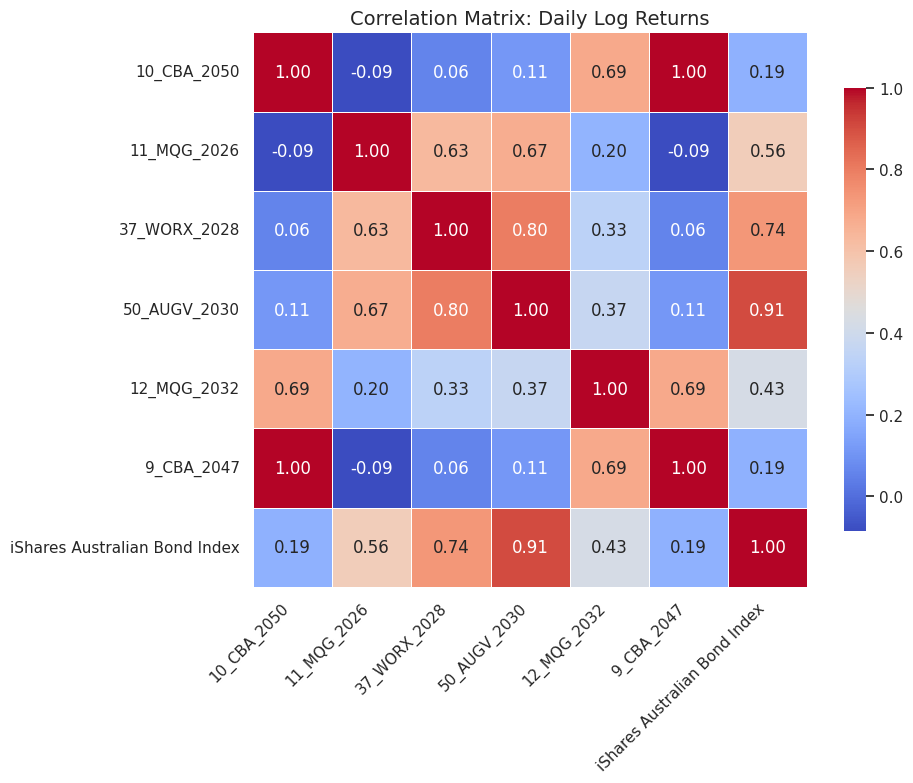

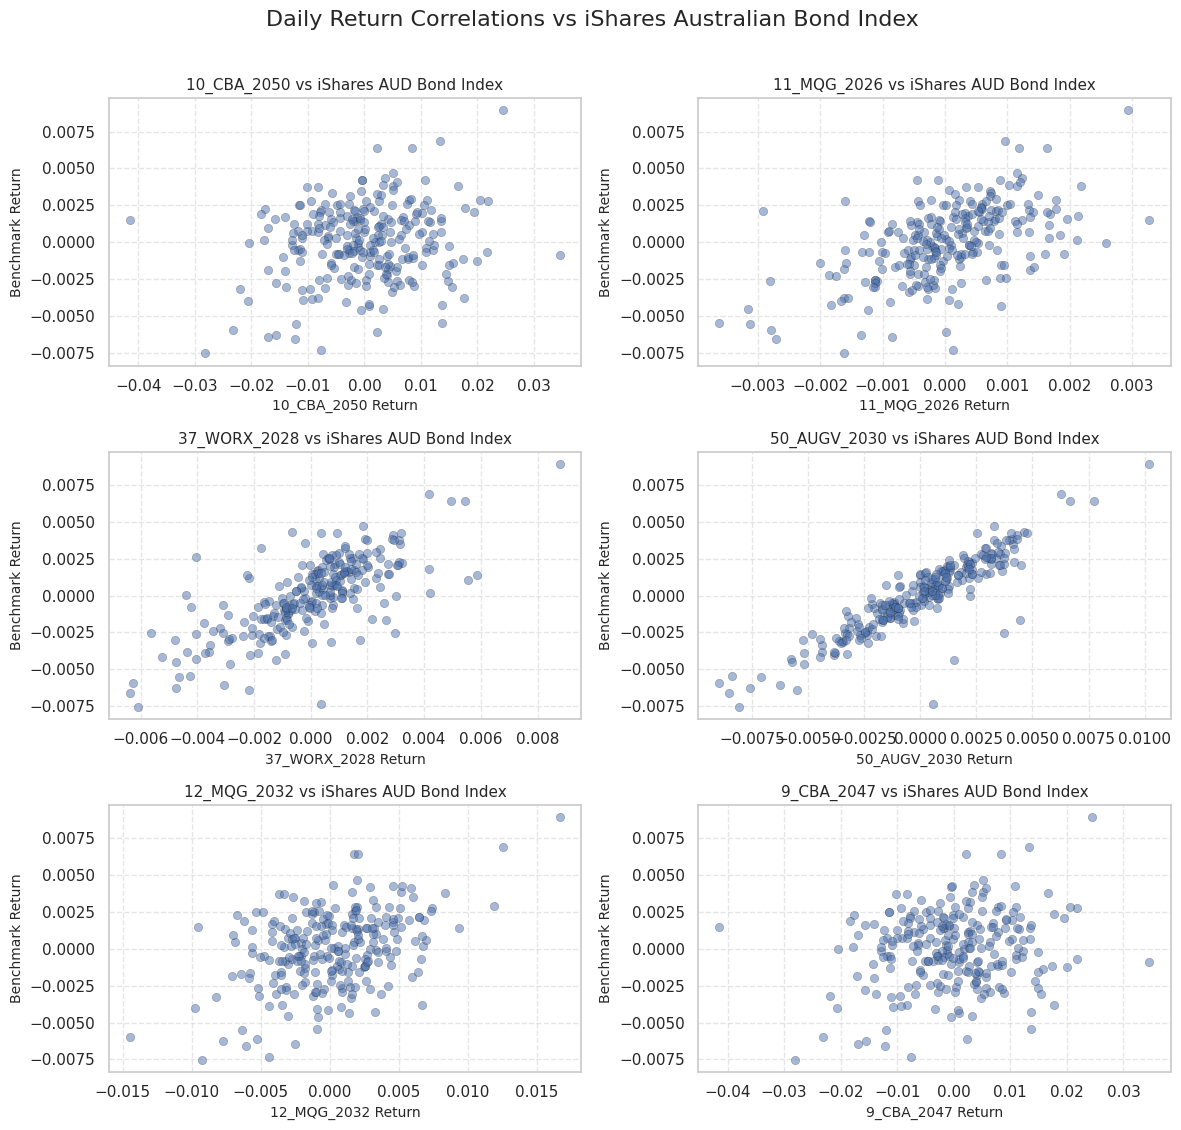

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Detect benchmark column dynamically ---
benchmark_col = log_returns.columns[-1]
bond_cols     = log_returns.columns[:-1]

# Build pretty labels
def pretty_name(col):
    return "iShares Australian Bond Index" if col == benchmark_col else col.replace("_Mid", "")

pretty_cols = [pretty_name(c) for c in log_returns.columns]

# 1) Correlation heatmap
corr = log_returns.corr()
corr.index = pretty_cols
corr.columns = pretty_cols

plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
sns.heatmap(
    corr, annot=True, fmt=".2f", cmap="coolwarm",
    square=True, linewidths=0.5, cbar_kws={"shrink": .8}
)
plt.title("Correlation Matrix: Daily Log Returns", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2) Scatterplots in 3×2 grid
benchmark_series = log_returns[benchmark_col]
bond_pretty     = [pretty_name(c) for c in bond_cols]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()
for ax, col, name in zip(axes, bond_cols, bond_pretty):
    ax.scatter(log_returns[col], benchmark_series,
               alpha=0.5, edgecolor='k', linewidth=0.3)
    ax.set_xlabel(f"{name} Return", fontsize=10)
    ax.set_ylabel("Benchmark Return", fontsize=10)
    ax.set_title(f"{name} vs iShares AUD Bond Index", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.5)

# remove any unused axes
for ax in axes[len(bond_cols):]:
    fig.delaxes(ax)

plt.suptitle("Daily Return Correlations vs iShares Australian Bond Index",
             fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()



### **Ex-Post Reweighting to Minimise Tracking Error**

This section details an optimization strategy applied ex-post to the existing portfolio to minimize its tracking error against the benchmark.

**Objective.** Identify the combination of weights for the six existing bonds that minimizes the volatility of the return differential relative to the benchmark.

**Mathematical formulation.**
$$\min_{w}\; \sigma\bigl(R_p(w) - R_b\bigr)$$
subject to
* $\sum_i w_i = 1$
* $w_i \ge 0$ for all $i$

where $R_p(w)$ is the daily weighted portfolio return, and $R_b$ is the daily benchmark return.

**Approach.**
1.  Prepare the daily return matrix for the six bonds and the daily return vector for the benchmark.
2.  Define the objective function that calculates the standard deviation of the difference $R_p - R_b$.
3.  Solve a constrained optimization problem (SLSQP method) to find the optimal weights.
4.  Calculate the new annualized tracking error and compare it with the original one.

**Limitations.**
* **Ex-post bias:** This method uses "future" data that is already known, which introduces a look-ahead bias and may not be replicable in real-time.
* **No transaction costs or turnover constraints:** The optimization does not account for the costs associated with rebalancing the portfolio to the new optimal weights, nor does it consider any limits on portfolio turnover.
* **Historical period dependency:** The results are highly dependent on the specific historical period chosen for the analysis. Optimal weights derived from one period may not be optimal for future periods.


In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
from IPython.display import display

# --- Section B.3: Ex-Post Reweighting with 3-Decimal Display Formatting ---

# 1) Prepare returns
bond_return_matrix = log_returns.iloc[:, :-1].values
benchmark_vector   = log_returns.iloc[:, -1].values
num_bonds          = bond_return_matrix.shape[1]

# 2) Objective function
def tracking_error_obj(w, B, b):
    rp   = B.dot(w)
    diff = rp - b
    return np.std(diff)

# 3) Initial weights, bounds, constraints
init_w      = np.ones(num_bonds) / num_bonds
bounds      = [(0, 1)] * num_bonds
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# 4) Optimize
res = minimize(
    tracking_error_obj,
    init_w,
    args=(bond_return_matrix, benchmark_vector),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
opt_w          = res.x
daily_te_opt   = res.fun
annual_te_opt  = daily_te_opt * np.sqrt(252)

# 5) Summary tables
df_opt_weights = pd.DataFrame({
    "Bond": log_returns.columns[:-1].str.replace("_Mid", ""),
    "Original W": weights,
    "Optimised W": opt_w
})

df_te = pd.DataFrame({
    "Metric": ["Original Daily TE", "Original Annual TE", "Optimised Daily TE", "Optimised Annual TE"],
    "Value (Decimal)": [
        tracking_error_daily, tracking_error_annualised,
        daily_te_opt, annual_te_opt
    ],
    "Value (bps)": [
        tracking_error_daily*10000, tracking_error_annualised*10000,
        daily_te_opt*10000, annual_te_opt*10000
    ]
})

# 6) Format last table to 3 decimals for display only
df_te_display = df_te.copy()
df_te_display["Value (Decimal)"] = df_te_display["Value (Decimal)"].map("{:.3f}".format)
df_te_display["Value (bps)"]     = df_te_display["Value (bps)"].map("{:.3f}".format)

df_opt_weights_display = df_opt_weights.copy()
df_opt_weights_display["Original W"] = df_opt_weights_display["Original W"].map("{:.3f}".format)
df_opt_weights_display["Optimised W"] = df_opt_weights_display["Optimised W"].map("{:.3f}".format)

# 7) Display
print("Optimal Weights:")
display(df_opt_weights_display)
print("\nTracking Error Comparison:")
display(df_te_display)


Optimal Weights:


,Bond,Original W,Optimised W
0,10_CBA_2050,0.220,0.015
1,11_MQG_2026,0.090,0.223
2,37_WORX_2028,0.160,0.285
3,50_AUGV_2030,0.120,0.463
4,12_MQG_2032,0.160,0.000
5,9_CBA_2047,0.250,0.015



Tracking Error Comparison:


,Metric,Value (Decimal),Value (bps)
0,Original Daily TE,0.005,49.834
1,Original Annual TE,0.079,791.086
2,Optimised Daily TE,0.001,11.711
3,Optimised Annual TE,0.019,185.907


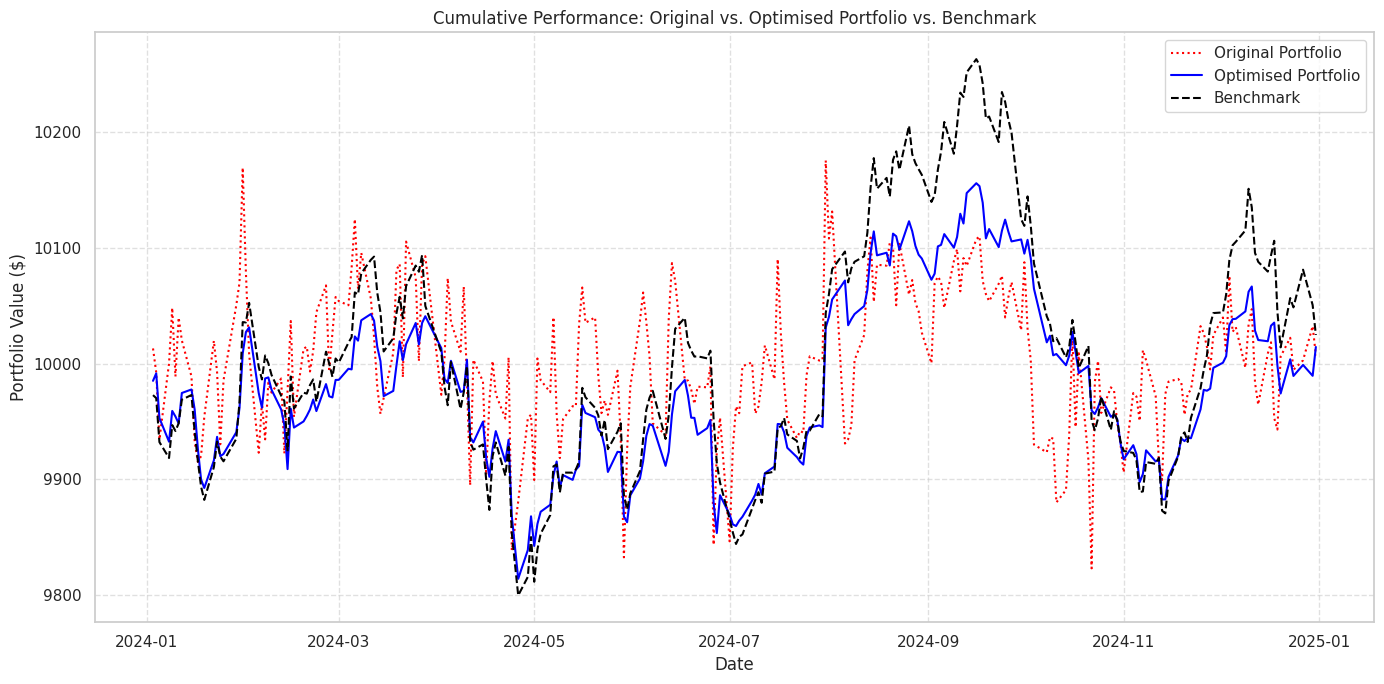

In [ ]:
# --- Section B.5: Visual Comparison of Cumulative Performance ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Calculate returns of the optimised portfolio
opt_rp = bond_return_matrix.dot(opt_w)

# 2) Create a DataFrame with all three return series aligned
df_perf_compare = pd.DataFrame({
    'Original Portfolio': portfolio_returns,
    'Optimised Portfolio': opt_rp,
    'Benchmark': benchmark_returns
}, index=log_returns.index).dropna()

# 3) Calculate cumulative performance from a base of $10,000
initial_value = 10000
df_cumulative = initial_value * np.exp(df_perf_compare.cumsum())

# 4) Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df_cumulative.index, df_cumulative['Original Portfolio'], label='Original Portfolio', color='red', linestyle=':')
plt.plot(df_cumulative.index, df_cumulative['Optimised Portfolio'], label='Optimised Portfolio', color='blue', linestyle='-')
plt.plot(df_cumulative.index, df_cumulative['Benchmark'], label='Benchmark', color='black', linestyle='--')

plt.title('Cumulative Performance: Original vs. Optimised Portfolio vs. Benchmark')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

---
## **Task D**

Imagine your company faces a liability due in six years (the basement date is 31st December 2024), and you are asked to assess whether your current bond portfolio is suitable for managing this liability through duration-based strategies. (24 marks)
- Begin by calculating the Macaulay duration of your portfolio using the weightings provided in the Excel file. Reflect on whether the current portfolio duration effectively matches the timing of the liability. If it does not, describe the steps you would take to adjust the portfolio weights to improve alignment and justify your choices based on your data.
- Now, assume you can rebalance the portfolio using other bonds from the provided list. Based on your understanding of immunisation theory, explain how you would construct an alternative portfolio and use the data to work on it.
- Drawing from both your findings and the academic literature, critically assess the strengths and limitations of the duration-matching approach in this real case.
- You have not constructed your portfolio using a cash flow matching approach. However, what steps would you need to take based on your current bond list if you were to match the liability using cash flow matching instead of duration matching? Comment on any practical challenges or limitations in this real case. (Hint: You may read the textbook about cash flow matching immunisation).

---


### **Data Preparation**

The first step in any duration-based analysis is to establish the relevant Yield to Maturity (YTM) for each bond as of the analysis date. For this task, the basement date is 31st December 2024. The YTM is a critical input, representing the total return an investor can expect if the bond is held to maturity, and is essential for accurately calculating the present value of future cash flows and, consequently, the bond's duration. The following code loads a file containing the mid-yields for each portfolio component on the specified date and merges this information into the main portfolio DataFrame.

In [ ]:
# --- Load YTM as of 31-Dec-2024 and merge into df_portfolio ---
import pandas as pd

# 1) Read the Excel file with YTMs
ytm_path = "YTM_31_12_2024_pf.xlsx"
df_ytm   = pd.read_excel(ytm_path)

# 2) Rename columns to match df_portfolio
df_ytm = df_ytm.rename(columns={
    "Instrument": "RIC/ISIN",
    "Mid Yield":  "YTM_2024"
})

# 3) Merge YTM into df_portfolio (left join to keep portfolio rows)
df_portfolio = df_portfolio.merge(
    df_ytm[["RIC/ISIN", "YTM_2024"]],
    on="RIC/ISIN",
    how="left"
)

# 4) Verify the merge
print("Portfolio with YTM at 31-Dec-2024:")
display(df_portfolio[["RIC/ISIN", "Bond Name", "Weight", "YTM_2024"]])



Portfolio with YTM at 31-Dec-2024:


,RIC/ISIN,Bond Name,Weight,YTM_2024
0,XS2223749958,CBA 3.300 26-AUG-2050,0.22,7.39
1,AU3CB0235281,MQG 4.250 28-JUL-2026 MTN,0.09,4.53
2,AU3CB0298487,WORX 5.950 13-OCT-2028 '28 MTN,0.16,5.59
3,AUG02500530=,AUGV 2.500 21-MAY-2030,0.12,3.99
4,XS2436881671,MQG 3.100 27-JAN-2032 MTN,0.16,5.10
5,XS1694223386,CBA 4.485 11-OCT-2047,0.25,5.69


### **Initial Analysis: Calculating Portfolio Macaulay Duration**

[cite_start]This section calculates the Macaulay Duration for each bond and the portfolio as a whole as of the basement date, 31st December 2024. Macaulay Duration is a crucial measure for immunisation as it represents the weighted-average time until a bond's cash flows are received, thus quantifying its interest rate sensitivity[cite: 23].

---
#### **Methodology Review: Accurate Duration Calculation with Partial Periods**
[cite_start]The Python function `calculate_bond_duration_accrued` is implemented to compute Macaulay Duration with high precision, specifically by accounting for settlement dates that fall between coupon payments, as required by standard industry practice and detailed in the course materials[cite: 73, 74]. This method is superior to simplified models that assume valuation occurs on a coupon date.

The function's logic is validated against the standard Macaulay Duration formula:
$$D_{Mac} = \frac{\sum_{i=1}^{N} t_i \times PV(CF_i)}{\sum_{i=1}^{N} PV(CF_i)}$$

Where $t_i$ is the time in years until the *i*-th cash flow is received, and $PV(CF_i)$ is its present value. The key adjustment is the precise calculation of each $t_i$.

1.  **Coupon Date Generation:**
    * The function begins by generating a precise schedule of all future coupon payment dates. It works backward from the `maturity_date` in intervals of 6 months (`relativedelta(months=6)`), ensuring accurate dates regardless of month length or leap years. This creates a list of all dates on which a cash flow will occur after the `settle_date`.

2.  **Partial Period Calculation (`v`):**
    * To handle the time between the `settle_date` and the *next* coupon payment, the code identifies the `next_coupon_date` and the `previous_coupon_date`.
    * It then calculates the variable `v` as the ratio: `(next_coupon_date - settle_date).days / (next_coupon_date - previous_coupon_date).days`. [cite_start]This value represents the fraction of the current coupon period remaining, a critical input for accurate discounting as per the lecture examples[cite: 75, 98].

3.  **Cash Flow Vector (`cf`):**
    * A vector is created containing the semi-annual coupon payment for each future coupon date. The `par_value` (face value) is correctly added to the very last cash flow to represent the bond's redemption.

4.  **Time-to-Cash-Flow Vector (`time_in_years`):**
    * This is the most critical step. A time vector is constructed where the time to the first cash flow is `v / freq`, the time to the second is `(v + 1) / freq`, and so on. This correctly maps each cash flow to its precise point in time (in years) from the settlement date.

5.  **Per-Period Yield (`per_period_ytm`):**
    * The annual YTM (in percentage) is correctly converted into a semi-annual decimal yield (`ytm_pct / 100 / freq`) for use in the discounting formula.

6.  **Present Value of Cash Flows (`pv_cf`):**
    * Each cash flow in the `cf` vector is discounted using the corresponding time from the `time_in_years` vector and the `per_period_ytm`. The formula used is $PV = CF / (1 + per\_period\_ytm)^{periods}$, where `periods` correctly incorporates the fractional period `v`.

7.  **Bond Price (Denominator):**
    * The theoretical price of the bond (dirty price) is calculated by summing all the individual `pv_cf` values. This becomes the denominator in the duration formula.

8.  **Final Duration Calculation (Numerator and Division):**
    * The numerator is calculated by summing the product of each cash flow's present value and its corresponding time in years (`pv_cf * time_in_years`).
    * This sum is then divided by the `bond_price` (the denominator) to yield the final, precise Macaulay Duration in years.

**Conclusion on Calculation Method:**
The `calculate_bond_duration_accrued` function correctly implements the industry-standard methodology for calculating Macaulay Duration on any given settlement date. By accurately handling partial periods, it provides a more robust and precise measure of interest rate risk than simplified models, aligning perfectly with the principles outlined in the course materials.

Table D1: Portfolio Duration Calculation
                     Bond Name  Weight  Duration  Weighted Duration
     MQG 4.250 28-JUL-2026 MTN    0.09    1.5143             0.1363
WORX 5.950 13-OCT-2028 '28 MTN    0.16    3.4039             0.5446
        AUGV 2.500 21-MAY-2030    0.12    5.0465             0.6056
     MQG 3.100 27-JAN-2032 MTN    0.16    6.2588             1.0014
         CBA 4.485 11-OCT-2047    0.25   13.5603             3.3901
         CBA 3.300 26-AUG-2050    0.22   13.7890             3.0336

Table D2: Duration Mismatch Summary
                     Metric  Value (years)
Portfolio Macaulay Duration         8.7115
          Liability Horizon         6.0000
    Duration Mismatch (Gap)         2.7115


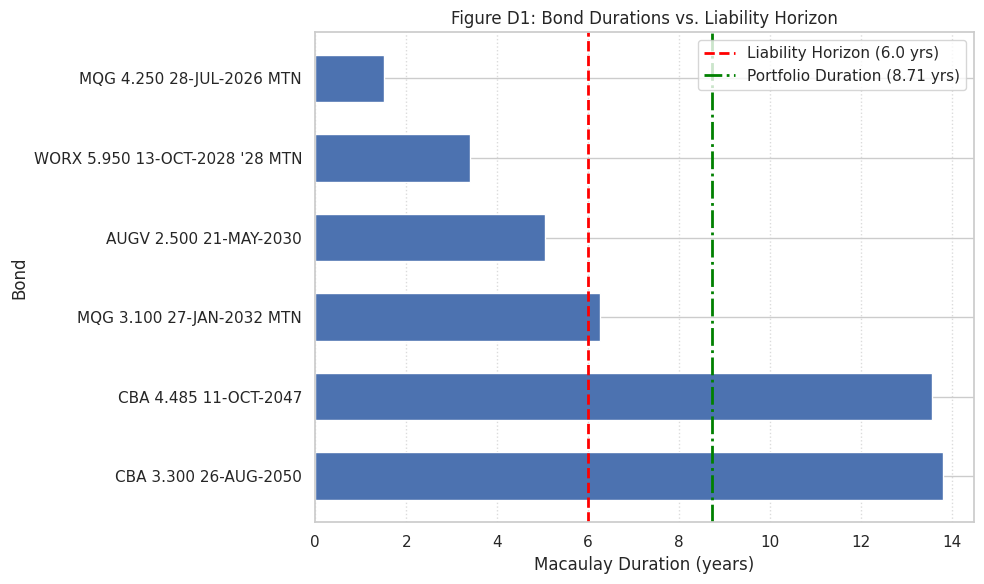

In [ ]:
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Part 2: Define Function and Parameters ---
def calculate_bond_duration_accrued(settle_date, maturity_date, coupon_pct, ytm_pct, par, freq=2):
    """
    Computes Macaulay Duration in years for a semi-annual pay bond,
    accurately handling partial periods between coupon dates.
    """
    if settle_date >= maturity_date:
        return 0.0

    # genera tutte le date di pagamento fino a maturity_date
    all_coupon_dates = []
    current_date = maturity_date
    delta_months = int(12 / freq)
    while current_date > settle_date:
        all_coupon_dates.append(current_date)
        current_date -= relativedelta(months=delta_months)
    all_coupon_dates.sort()

    # se non ci sono cedole future, duration = anni residui
    if not all_coupon_dates:
        return (maturity_date - settle_date).days / 365.25

    # frazione di periodo corrente
    next_coupon = all_coupon_dates[0]
    prev_coupon = next_coupon - relativedelta(months=delta_months)
    days_in_period = (next_coupon - prev_coupon).days
    if days_in_period == 0:
        return 0.0
    v = (next_coupon - settle_date).days / days_in_period

    # flussi di cassa
    coupon_payment = (coupon_pct / 100 * par) / freq
    per_period_ytm = (ytm_pct / 100) / freq
    df_cf = pd.DataFrame({'date': all_coupon_dates})
    df_cf['cf'] = coupon_payment
    df_cf.at[df_cf.index[-1], 'cf'] += par
    df_cf['periods_to_cf'] = np.arange(len(all_coupon_dates)) + v
    df_cf['pv_cf'] = df_cf['cf'] / ((1 + per_period_ytm) ** df_cf['periods_to_cf'])

    bond_price = df_cf['pv_cf'].sum()
    if bond_price == 0:
        return 0.0

    # Macaulay duration
    df_cf['time_in_years'] = df_cf['periods_to_cf'] / freq
    mac_dur = (df_cf['time_in_years'] * df_cf['pv_cf']).sum() / bond_price
    return mac_dur

# --- FIX: Define all necessary parameters before use ---
baseline_date = pd.to_datetime("2024-12-31")
par_value = 100.0
liability_horizon = 6.0

# --- Part 3: Calculate Durations and Generate Outputs ---
df_dur = df_portfolio.copy()
df_dur.dropna(subset=['YTM_2024'], inplace=True)  # rimuove righe senza YTM

df_dur["Duration"] = df_dur.apply(
    lambda row: calculate_bond_duration_accrued(
        baseline_date,
        row["Maturity Date"],
        row["Coupon (%)"],
        row["YTM_2024"],
        par_value
    ),
    axis=1
)

df_dur["Weighted Duration"] = df_dur["Duration"] * df_dur["Weight"]
portfolio_duration = df_dur["Weighted Duration"].sum()

# Table D1: Detailed Duration Calculation
print("Table D1: Portfolio Duration Calculation")
df_display = (
    df_dur[["Bond Name", "Weight", "Duration", "Weighted Duration"]]
    .sort_values("Duration")
    .round(4)
)
print(df_display.to_string(index=False))

# Table D2: Summary of Duration Mismatch
summary_data = {
    "Metric": [
        "Portfolio Macaulay Duration",
        "Liability Horizon",
        "Duration Mismatch (Gap)"
    ],
    "Value (years)": [
        round(portfolio_duration, 4),
        liability_horizon,
        round(portfolio_duration - liability_horizon, 4)
    ]
}
df_summary = pd.DataFrame(summary_data)
print("\nTable D2: Duration Mismatch Summary")
print(df_summary.to_string(index=False))

# Figure D1: Duration Comparison Chart
df_chart = df_dur.sort_values("Duration", ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(df_chart["Bond Name"], df_chart["Duration"], height=0.6)
plt.axvline(liability_horizon, color='red', linestyle='--', linewidth=2,
            label=f"Liability Horizon ({liability_horizon} yrs)")
plt.axvline(portfolio_duration, color='green', linestyle='-.', linewidth=2,
            label=f"Portfolio Duration ({portfolio_duration:.2f} yrs)")
plt.title("Figure D1: Bond Durations vs. Liability Horizon")
plt.xlabel("Macaulay Duration (years)")
plt.ylabel("Bond")
plt.legend()
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


### **Strategy 1: Re-weighting the Existing Portfolio for Duration-Matching**
The initial analysis revealed a significant duration mismatch. This first immunisation strategy involves adjusting the weights of the existing six bonds to force the portfolio's duration to match the 6-year liability horizon. This is framed as a constrained optimisation problem where the goal is to find a new set of weights that achieves the target duration while minimising the deviation from the original portfolio allocation.

In [ ]:
# --- Task D.3: Reweight Existing Bonds to Match 6-Year Horizon ---
from scipy.optimize import minimize
import numpy as np

# It is assumed the df_dur DataFrame from the previous step is available.
# This DataFrame should contain the original 6 bonds and their calculated durations.

# Extract durations and initial weights into numpy arrays for the optimizer
D_vector = df_dur["Duration"].values
w_original = df_dur["Weight"].values
target_duration = 6.0

# Define the objective function: minimize the sum of squared differences
# from the original weights. This seeks the "closest" solution to the original portfolio.
def objective_function(w, w_orig):
    return np.sum((w - w_orig)**2)

# Define the constraints for the optimizer:
# 1. The sum of the new weights must equal 1 (fully invested).
# 2. The weighted average duration of the new portfolio must equal the target.
constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
    {"type": "eq", "fun": lambda w: np.dot(w, D_vector) - target_duration}
]

# Define the bounds for each weight (0 to 1), prohibiting short selling.
bounds = [(0, 1)] * len(w_original)

# Run the optimization
solution = minimize(
    objective_function,
    w_original,
    args=(w_original,),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

# --- Output for the Report ---
# This table shows the required adjustment in weights.
if solution.success:
    w_adjusted = solution.x

    # Create the output DataFrame
    df_adjusted_weights = pd.DataFrame({
        "Bond Name": df_dur["Bond Name"],
        "Original Weight": w_original,
        "Adjusted Weight": w_adjusted
    })

    print("Table_4.3: Adjusted Weights for Constrained Immunisation")
    display(df_adjusted_weights.round(4))

    # Verify the new portfolio duration
    new_portfolio_duration = np.dot(w_adjusted, D_vector)
    print(f"\nVerification: New Portfolio Duration = {new_portfolio_duration:.4f} years")
else:
    print("Optimization was not successful.")
    print(f"Solver message: {solution.message}")

Table_4.3: Adjusted Weights for Constrained Immunisation


,Bond Name,Original Weight,Adjusted Weight
0,CBA 3.300 26-AUG-2050,0.22,0.0900
1,MQG 4.250 28-JUL-2026 MTN,0.09,0.2045
2,WORX 5.950 13-OCT-2028 '28 MTN,0.16,0.2369
3,AUGV 2.500 21-MAY-2030,0.12,0.1641
4,MQG 3.100 27-JAN-2032 MTN,0.16,0.1800
5,CBA 4.485 11-OCT-2047,0.25,0.1245



Verification: New Portfolio Duration = 6.0000 years


### **Immunisation Strategy 2: Building a Dedicated Portfolio**


#### **Step 1: Loading and Cleaning the Complete Historical Price Dataset**
To perform the advanced analysis, we first load and process the complete historical daily price data for all securities. The provided file contains Bid and Ask prices for each bond. This initial step involves cleaning the data, handling missing values, and calculating a consistent mid-price for every bond and the benchmark. The result is a clean, aligned matrix of mid-prices for the entire investment universe.

In [ ]:
#Step 1
import pandas as pd
import numpy as np
import re

# Define the dictionary containing all 61 bonds from the provided list.
all_bonds_data = {
    "Bond Code": [
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61
    ],
    "RIC/ISIN": [
        "AU3CB0235158", "AU3CB0243525", "XS0880275317", "XS1785312395", "XS2095795881",
        "AU3CB0234623", "AU3CB0245744", "XS1774631599", "XS1694223386", "XS2223749958",
        "AU3CB0235281", "XS2436881671", "AU3CB0244580", "XS2423738041", "XS1789642243",
        "XS2447563441", "AU3CB0234573", "AU3CB0305860", "XS2126049332", "AU3CB0283406",
        "AU3CB0303543", "AU3CB0283414", "AU3CB0268126", "AU3CB0268134", "AU3CB0304772",
        "AU3CB0240109", "AU3CB0274280", "AU3CB0243764", "AU3CB0307387", "AU3CB0285005",
        "AU3CB0267847", "AU3CB0239366", "AU3CB0270635", "AU3CB0279560", "AU3CB0262350",
        "AU3CB0278703", "AU3CB0298487", "AU3CB0279560", "AU3CB0280030", "AU3CB0281046",
        "AUG03250425=", "AUG00251125=", "AUG04250426=", "AUG04750427=", "AUG02750427=",
        "AUG02250528=", "AUG02751128=", "AUG03250429=", "AUG02751129=", "AUG02500530=",
        "AUG01001230=", "AUG01500631=", "AUG01001131=", "AUG01250532=", "AUG04500433=",
        "AUG02750635=", "AUG03750437=", "AUG03250639=", "AUG02750541=", "AUG03000347=",
        "AUG01750651="
    ],
    "Issuer": [
        "ANZ", "ANZ", "ANZ", "ANZ", "ANZ", "COMMONWEALTH", "COMMONWEALTH", "COMMONWEALTH",
        "COMMONWEALTH", "COMMONWEALTH", "MACQUARIE GROUP LTD", "MACQUARIE GROUP LTD", "NAB",
        "NAB", "NAB", "NAB", "WEST PAC", "WEST PAC", "WEST PAC", "WOOLWORTHS GROUP LTD",
        "WOOLWORTHS GROUP LTD", "WOOLWORTHS GROUP LTD", "COLES GROUP LTD", "COLES GROUP LTD",
        "COLES GROUP LTD", "QANTAS AIRWAYS LTD", "QANTAS AIRWAYS LTD", "TELSTRA CORP. LTD",
        "TELSTRA CORP. LTD", "COMPUTERSHARE US INC", "ORIGIN ENERGY LTD", "GPT GROUP",
        "GPT GROUP", "CHARTER HALL GROUP", "BWP TRUST", "BWP TRUST", "WORLEY FINANICAL SERVICES PTY LTD",
        "CHARTER HALL GROUP", "BANK OF QUEENSLAND LTDBO", "WESFARMERS LTD",
        "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND",
        "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND",
        "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND",
        "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND",
        "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND",
        "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND",
        "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND", "AUSTRALIAN GOVERNMENT BOND"
    ],
    "Bond Name": [
        "ANZ 4.000 22-JUL-2026 MTN", "ANZ 4.100 28-SEP-2027 MTN", "ANZ 5.070 31-JAN-2028 MTN",
        "ANZ 4.045 28-FEB-2033 MTN", "ANZ 3.400 20-DEC-2039", "CBA 4.200 11-JUN-2026 MTN",
        "CBA 3.750 25-JAN-2028 MTN", "CBA 4.230 23-FEB-2033 MTN", "CBA 4.485 11-OCT-2047 MTN",
        "CBA 3.300 26-AUG-2050", "MQG 4.250 28-JUL-2026 MTN", "MQG 3.100 27-JAN-2032 MTN",
        "NAB 3.750 25-MAY-2027", "NAB 5.230 20-DEC-2031 FRN MTN", "NAB 4.100 09-MAR-2038 MTN",
        "NAB 4.100 24-FEB-2042", "WBC 4.125 04-JUN-2026 MTN", "WBC 5.000 15-JAN-2029 MTN",
        "WBC 2.350 27-FEB-2040 MTN", "WOW 1.850 15-NOV-2027 '27 MTN", "WOW 5.762 18-APR-2031 '31 MTN",
        "WOW 2.750 15-NOV-2031 '31 MTN", "COLGR 2.200 06-NOV-2026 '26 MTN",
        "COLGR 2.650 06-NOV-2029 '29 MTN", "COLGR 6.208 28-NOV-2033 '33 MTN",
        "QAN 4.750 12-OCT-2026 MTN", "QAN 5.250 09-SEP-2030 '30 MTN",
        "TESAG 4.000 19-APR-2027 MTN", "TESAG 5.650 06-MAR-2034 '33 MTN",
        "CPU 3.147 30-NOV-2027 '27 MTN", "ORG 2.650 11-NOV-2027 '27 MTN",
        "GPTX 3.657 24-AUG-2026 '26 MTN", "GPTX 2.849 20-FEB-2032 '31 MTN",
        "CHC 3.092 21-APR-2031 '31 MTN", "BWP 3.300 10-APR-2026 '26 MTN",
        "BWP 2.200 24-MAR-2028 '28 MTN", "WORX 5.950 13-OCT-2028 '28 MTN",
        "CHC 3.092 21-APR-2031 '31 MTN", "BOQ 1.400 06-MAY-2026 MTN",
        "WES 1.941 23-JUN-2028 '28 MTN", "AUGV 3.250 21-APR-2025", "AUGV 0.250 21-NOV-2025",
        "AUGV 4.250 21-APR-2026", "AUGV 4.750 21-APR-2027", "AUGV 2.750 21-NOV-2027",
        "AUGV 2.250 21-MAY-2028", "AUGV 2.750 21-NOV-2028", "AUGV 3.250 21-APR-2029",
        "AUGV 2.750 21-NOV-2029", "AUGV 2.500 21-MAY-2030", "AUGV 1.000 21-DEC-2030",
        "AUGV 1.500 21-JUN-2031", "AUGV 1.000 21-NOV-2031", "AUGV 1.250 21-MAY-2032",
        "AUGV 4.500 21-APR-2033", "AUGV 2.750 21-JUN-2035", "AUGV 3.750 21-APR-2037",
        "AUGV 3.250 21-JUN-2039", "AUGV 2.750 21-MAY-2041", "AUGV 3.000 21-MAR-2047",
        "AUGV 1.750 21-JUN-2051"
    ]
}

# Convert the dictionary to a pandas DataFrame
df_all_bonds = pd.DataFrame(all_bonds_data)

# Helper functions to parse bond details from its name
def extract_coupon(bond_name):
    """Extracts the coupon rate from the bond name string."""
    match = re.search(r'(\d{1,2}\.\d{3})', str(bond_name))
    return float(match.group(1)) if match else np.nan

def extract_maturity(bond_name):
    """Extracts the maturity date from the bond name string."""
    match = re.search(r'(\d{2}-[A-Z]{3}-\d{4})', str(bond_name))
    return pd.to_datetime(match.group(), format='%d-%b-%Y') if match else pd.NaT

# Apply the functions to create the new columns
df_all_bonds['Coupon (%)'] = df_all_bonds['Bond Name'].apply(extract_coupon)
df_all_bonds['Maturity Date'] = df_all_bonds['Bond Name'].apply(extract_maturity)

# Clean out any rows where parsing might have failed (e.g., Floating Rate Notes)
# This is crucial for ensuring the subsequent calculations run without errors.
original_rows = len(df_all_bonds)
df_all_bonds.dropna(subset=['Coupon (%)', 'Maturity Date'], inplace=True)
cleaned_rows = len(df_all_bonds)

# --- Verification and Output ---
print("Master list of all available bonds created and enriched.")
print(f"Removed {original_rows - cleaned_rows} rows due to parsing errors (e.g., FRNs).")
print(f"Total valid bonds for analysis: {cleaned_rows}")
df_all_bonds

Master list of all available bonds created and enriched.
Removed 0 rows due to parsing errors (e.g., FRNs).
Total valid bonds for analysis: 61


,Bond Code,RIC/ISIN,Issuer,Bond Name,Coupon (%),Maturity Date
0,1,AU3CB0235158,ANZ,ANZ 4.000 22-JUL-2026 MTN,4.000,2026-07-22
1,2,AU3CB0243525,ANZ,ANZ 4.100 28-SEP-2027 MTN,4.100,2027-09-28
2,3,XS0880275317,ANZ,ANZ 5.070 31-JAN-2028 MTN,5.070,2028-01-31
3,4,XS1785312395,ANZ,ANZ 4.045 28-FEB-2033 MTN,4.045,2033-02-28
4,5,XS2095795881,ANZ,ANZ 3.400 20-DEC-2039,3.400,2039-12-20
...,...,...,...,...,...,...
56,57,AUG03750437=,AUSTRALIAN GOVERNMENT BOND,AUGV 3.750 21-APR-2037,3.750,2037-04-21
57,58,AUG03250639=,AUSTRALIAN GOVERNMENT BOND,AUGV 3.250 21-JUN-2039,3.250,2039-06-21
58,59,AUG02750541=,AUSTRALIAN GOVERNMENT BOND,AUGV 2.750 21-MAY-2041,2.750,2041-05-21
59,60,AUG03000347=,AUSTRALIAN GOVERNMENT BOND,AUGV 3.000 21-MAR-2047,3.000,2047-03-21


In [ ]:
import pandas as pd
import numpy as np
import re
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

# It is assumed df_all_bonds is available from a previous step.
# Load the YTM data for all bonds from the XLSX file
ytm_all_path = "YTM_31_12_2024_pf_all.xlsx"
df_ytm_all = pd.read_excel(ytm_all_path)

# Prepare the YTM dataframe for merging
df_ytm_all = df_ytm_all.rename(columns={"Instrument": "RIC/ISIN", "Mid Yield": "YTM_2024"})

# Merge the master bond list with the YTM data
df_master = df_all_bonds.merge(
    df_ytm_all[["RIC/ISIN", "YTM_2024"]],
    on="RIC/ISIN",
    how="left"
)

# --- FIX: Convert YTM column to numeric and clean data ---
# Coerce non-numeric values to NaN (Not a Number)
df_master['YTM_2024'] = pd.to_numeric(df_master['YTM_2024'], errors='coerce')

# Now, safely drop rows with NaN and filter for positive yields
original_count = len(df_master)
df_master.dropna(subset=['YTM_2024'], inplace=True)
df_master = df_master[df_master['YTM_2024'] > 0]
cleaned_count = len(df_master)

print(f"Merged master dataset created. Removed {original_count - cleaned_count} bonds with missing/invalid YTM.")
print(f"Final bond universe size: {cleaned_count}")
df_master.head()


Merged master dataset created. Removed 6 bonds with missing/invalid YTM.
Final bond universe size: 57


,Bond Code,RIC/ISIN,Issuer,Bond Name,Coupon (%),Maturity Date,YTM_2024
0,1,AU3CB0235158,ANZ,ANZ 4.000 22-JUL-2026 MTN,4.000,2026-07-22,4.45
1,2,AU3CB0243525,ANZ,ANZ 4.100 28-SEP-2027 MTN,4.100,2027-09-28,4.53
2,3,XS0880275317,ANZ,ANZ 5.070 31-JAN-2028 MTN,5.070,2028-01-31,4.85
3,4,XS1785312395,ANZ,ANZ 4.045 28-FEB-2033 MTN,4.045,2033-02-28,5.26
4,5,XS2095795881,ANZ,ANZ 3.400 20-DEC-2039,3.400,2039-12-20,7.11


In [ ]:
df_master.tail()

,Bond Code,RIC/ISIN,Issuer,Bond Name,Coupon (%),Maturity Date,YTM_2024
58,57,AUG03750437=,AUSTRALIAN GOVERNMENT BOND,AUGV 3.750 21-APR-2037,3.75,2037-04-21,4.48
59,58,AUG03250639=,AUSTRALIAN GOVERNMENT BOND,AUGV 3.250 21-JUN-2039,3.25,2039-06-21,4.56
60,59,AUG02750541=,AUSTRALIAN GOVERNMENT BOND,AUGV 2.750 21-MAY-2041,2.75,2041-05-21,4.68
61,60,AUG03000347=,AUSTRALIAN GOVERNMENT BOND,AUGV 3.000 21-MAR-2047,3.00,2047-03-21,4.87
62,61,AUG01750651=,AUSTRALIAN GOVERNMENT BOND,AUGV 1.750 21-JUN-2051,1.75,2051-06-21,4.88


#### **Step 2: Calculating Duration for the Entire Bond Universe**
With a complete and clean dataset, we now apply our accurate calculate_bond_duration_accrued function to every bond in the master list. This will provide the precise Macaulay Duration for each security as of our valuation date (31st December 2024), creating the necessary data for our selection process.

In [ ]:
# --- Step 2: Calculate Duration for All Bonds ---

# It is assumed df_master from the previous step is available.
# The accurate duration function must be defined to be used.
from dateutil.relativedelta import relativedelta

def calculate_bond_duration_accrued(settle_date, maturity_date, coupon_pct, ytm_pct, par, freq=2):
    """
    Computes Macaulay Duration in years for a semi-annual pay bond,
    accurately handling partial periods between coupon dates.
    """
    if settle_date >= maturity_date:
        return 0

    # Generate all coupon dates by working backwards from maturity
    all_coupon_dates = []
    current_date = maturity_date
    while current_date > settle_date:
        all_coupon_dates.append(current_date)
        current_date -= relativedelta(months=int(12/freq))
    all_coupon_dates.sort()

    if not all_coupon_dates:
        # This case handles zero-coupon bonds or bonds maturing before next coupon
        years_to_maturity = (maturity_date - settle_date).days / 365.25
        return years_to_maturity

    # Determine current coupon period
    next_coupon_date = all_coupon_dates[0]
    previous_coupon_date = next_coupon_date - relativedelta(months=int(12/freq))

    # Calculate v - the fraction of the period remaining until the next coupon
    days_in_period = (next_coupon_date - previous_coupon_date).days
    if days_in_period == 0: return 0 # Avoid division by zero
    days_to_next_coupon = (next_coupon_date - settle_date).days
    v = days_to_next_coupon / days_in_period

    # Per-period parameters
    coupon_payment = (coupon_pct / 100 * par) / freq
    per_period_ytm = (ytm_pct / 100) / freq

    # Create a DataFrame for all future cash flows
    cash_flows_df = pd.DataFrame({'date': all_coupon_dates})
    cash_flows_df['cf'] = coupon_payment
    cash_flows_df.loc[cash_flows_df.index[-1], 'cf'] += par # Add principal to final CF

    # Calculate time to each cash flow in semi-annual periods from settlement
    cash_flows_df['periods_to_cf'] = np.arange(len(all_coupon_dates)) + v

    # Calculate Present Value for each cash flow
    cash_flows_df['pv_cf'] = cash_flows_df['cf'] / ((1 + per_period_ytm) ** cash_flows_df['periods_to_cf'])

    # Bond price is the sum of the present values of all future cash flows
    bond_price = cash_flows_df['pv_cf'].sum()
    if bond_price == 0: return 0 # Avoid division by zero

    # Calculate Macaulay Duration
    # Time to CF in years = periods_to_cf / frequency
    cash_flows_df['time_in_years'] = cash_flows_df['periods_to_cf'] / freq
    mac_dur = np.sum(cash_flows_df['time_in_years'] * cash_flows_df['pv_cf']) / bond_price

    return mac_dur

# --- Apply the function to the master DataFrame ---
print("Calculating Macaulay Duration for all bonds...")

baseline_date = pd.to_datetime("2024-12-31")
par_value = 100

df_master["Duration"] = df_master.apply(
    lambda row: calculate_bond_duration_accrued(
        baseline_date, row["Maturity Date"], row["Coupon (%)"], row["YTM_2024"], par_value
    ),
    axis=1
)

print("Duration calculation complete.")

# --- Verification and Output ---
# Display a sample of the results to verify the new 'Duration' column
display(df_master[["Bond Code", "Issuer", "Bond Name", "Duration"]].head())
display(df_master[["Bond Code", "Issuer", "Bond Name", "Duration"]].tail())

Calculating Macaulay Duration for all bonds...
Duration calculation complete.


,Bond Code,Issuer,Bond Name,Duration
0,1,ANZ,ANZ 4.000 22-JUL-2026 MTN,1.501438
1,2,ANZ,ANZ 4.100 28-SEP-2027 MTN,2.592590
2,3,ANZ,ANZ 5.070 31-JAN-2028 MTN,2.836119
3,4,ANZ,ANZ 4.045 28-FEB-2033 MTN,6.871306
4,5,ANZ,ANZ 3.400 20-DEC-2039,10.961188


,Bond Code,Issuer,Bond Name,Duration
58,57,AUSTRALIAN GOVERNMENT BOND,AUGV 3.750 21-APR-2037,9.791027
59,58,AUSTRALIAN GOVERNMENT BOND,AUGV 3.250 21-JUN-2039,11.384438
60,59,AUSTRALIAN GOVERNMENT BOND,AUGV 2.750 21-MAY-2041,12.753508
61,60,AUSTRALIAN GOVERNMENT BOND,AUGV 3.000 21-MAR-2047,15.128074
62,61,AUSTRALIAN GOVERNMENT BOND,AUGV 1.750 21-JUN-2051,18.892489


#### **Step 3: Load, Clean, and Align All Historical Price Data**
This step loads the final, complete dataset containing the historical mid-prices for all bonds and the benchmark. Following the instructions, the only cleaning performed is the removal of any entire column (instrument) that contains errors or missing data. Daily log returns are then calculated for the final, clean set of securities.

In [ ]:
# --- Step 3: Load Final Dataset and Calculate Log Returns ---
import pandas as pd
import numpy as np

print("--- Step 3: Loading the final, unified price data file ---")

# Load the single, complete dataset provided.
prices_path = 'YTM_31_12_2024_pf_all_r_value.xlsx'
df_prices_raw = pd.read_excel(prices_path)

# Set the first column as the 'Date' index
df_prices_raw = df_prices_raw.rename(columns={df_prices_raw.columns[0]: 'Date'})
df_prices_raw['Date'] = pd.to_datetime(df_prices_raw['Date'], dayfirst=True)
df_prices_raw = df_prices_raw.set_index('Date').sort_index()

# Convert all price columns to numeric, turning any text/errors into NaN
for col in df_prices_raw.columns:
    df_prices_raw[col] = pd.to_numeric(df_prices_raw[col], errors='coerce')

# --- As per your instructions: Remove any COLUMN that contains any error (NaN) ---
original_cols = len(df_prices_raw.columns)
df_prices_clean = df_prices_raw.dropna(axis=1, how='any')
cleaned_cols = len(df_prices_clean.columns)

print(f"Removed {original_cols - cleaned_cols} instruments due to missing data points.")

# Calculate daily log returns from the final clean price data
log_returns_complete = np.log(df_prices_clean / df_prices_clean.shift(1))

# Drop the first row which will be all NaNs due to the .shift(1) operation
log_returns_complete.dropna(inplace=True)

print(f"\nLog returns successfully calculated for {log_returns_complete.shape[1]} instruments over {len(log_returns_complete)} days.")
print("Data preparation is complete. You can now proceed with the next steps.")
display(log_returns_complete.head())

--- Step 3: Loading the final, unified price data file ---
Removed 9 instruments due to missing data points.

Log returns successfully calculated for 53 instruments over 260 days.
Data preparation is complete. You can now proceed with the next steps.


,AU3CB0235158,AU3CB0243525,XS0880275317,XS1785312395,XS2095795881,AU3CB0234623,AU3CB0245744,XS1774631599,XS1694223386,XS2223749958,...,AUG01001131=,AUG01250532=,AUG04500433=,AUG02750635=,AUG03750437=,AUG03250639=,AUG02750541=,AUG03000347=,AUG01750651=,LP63511336
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,-0.001136,-0.002882,0.000000,0.001183,-0.004975,-0.001362,-0.001512,0.000447,-0.000165,0.004146,...,-0.002081,-0.002192,-0.002015,-0.002378,-0.002471,-0.002816,-0.002829,-0.003517,-0.003842,-0.002729
2024-01-04,-0.000081,-0.000714,-0.003974,-0.008915,-0.007153,-0.000162,-0.001140,-0.008191,-0.014213,-0.003131,...,0.001035,0.000942,0.000801,0.001127,0.001002,0.001172,0.001125,0.000451,-0.000550,-0.000259
2024-01-05,-0.001960,-0.002442,-0.001262,-0.002971,-0.011908,-0.001333,-0.003075,-0.005870,-0.010571,-0.008298,...,-0.005499,-0.005938,-0.005997,-0.007720,-0.008178,-0.009349,-0.010421,-0.012331,-0.015300,-0.003813
2024-01-08,-0.001424,-0.002017,-0.000408,-0.001437,0.002148,-0.001507,-0.002824,0.002185,0.004446,0.015704,...,-0.003918,-0.003857,-0.003966,-0.005023,-0.005451,-0.006159,-0.007394,-0.009164,-0.011308,-0.001384
2024-01-09,0.001211,0.001506,0.001521,0.002645,-0.000322,0.001234,0.002501,0.002631,0.003193,0.007842,...,0.004995,0.005115,0.004945,0.006226,0.006596,0.007966,0.009352,0.011318,0.013227,0.002860


#### **Step 4: Consolidating All Data for Optimisation**
Now that we have the complete log returns, this crucial step consolidates all necessary data points into a single DataFrame. It takes the time-series data (log_returns_complete) and the static data (bond characteristics and durations from df_master) and joins them. This ensures all inputs—returns, durations, and bond identifiers—are perfectly aligned before being passed to the optimisation function.

In [ ]:
# --- Step 4: Consolidating All Data for Optimization ---

# It is assumed df_master (with durations) and log_returns_complete are available.
print("--- Step 4: Consolidating all data for optimization ---")

# Transpose the log returns DataFrame to work with bond RICs as a column
log_returns_T = log_returns_complete.T.reset_index().rename(columns={'index': 'RIC/ISIN'})

# Isolate the benchmark series cleanly
benchmark_ric_identifier = 'LP63511336'
benchmark_row = log_returns_T[log_returns_T['RIC/ISIN'] == benchmark_ric_identifier]
benchmark_returns_series = benchmark_row.iloc[0, 1:].astype(float)

# Isolate the bond data
bond_log_returns_T = log_returns_T[log_returns_T['RIC/ISIN'] != benchmark_ric_identifier]

# Merge bond returns with their calculated durations
df_model_data = bond_log_returns_T.merge(df_master[['RIC/ISIN', 'Duration', 'Bond Name']], on='RIC/ISIN', how='inner')

# Prepare the final inputs for the optimizer
bond_returns_matrix = df_model_data.drop(columns=['RIC/ISIN', 'Duration', 'Bond Name']).T.values.astype(float)
bond_durations_vector = df_model_data['Duration'].values
bond_rics_final = df_model_data['RIC/ISIN'].tolist()

print(f"Final dataset for optimization created with {len(bond_rics_final)} bonds.")

# Final verification to ensure alignment
if benchmark_returns_series.shape[0] == bond_returns_matrix.shape[0]:
    print("Alignment successful: Benchmark and bond return series have the same length.")
else:
     raise ValueError(f"CRITICAL ERROR: Mismatch in length. Benchmark: {benchmark_returns_series.shape[0]}, Bonds: {bond_returns_matrix.shape[0]}")

--- Step 4: Consolidating all data for optimization ---
Final dataset for optimization created with 52 bonds.
Alignment successful: Benchmark and bond return series have the same length.


#### **Step 5: Candidate Selection via Correlation Analysis**
To make the optimisation more efficient, we pre-select a pool of the most promising candidates. This is done by calculating each bond's historical correlation with the benchmark index and selecting the top 15. This step includes a safeguard to filter out any bonds with a near-perfect correlation, which would indicate a data error.

In [ ]:
# --- Step 5: Candidate Selection via Correlation Analysis ---
print("\n--- Step 3: Pre-selecting Candidates based on Correlation ---")

# Calculate the correlation of each bond with the benchmark
correlations = [np.corrcoef(bond_returns_matrix[:, i], benchmark_returns_series)[0, 1] for i in range(bond_returns_matrix.shape[1])]
df_model_data['Correlation'] = correlations

# Filter out any bonds with a near-perfect correlation (>0.9999) to handle data anomalies
df_model_data_filtered = df_model_data[df_model_data['Correlation'] < 0.9999].copy()
print(f"Removed {len(df_model_data) - len(df_model_data_filtered)} bond(s) with near-perfect correlation before selection.")

# Select the top 15 bonds from the cleaned list
candidate_pool_size = 15
actual_pool_size = min(candidate_pool_size, len(df_model_data_filtered))
df_candidate_pool = df_model_data_filtered.sort_values(by='Correlation', ascending=False).head(actual_pool_size)

print(f"Selected a candidate pool of {len(df_candidate_pool)} bonds with the highest genuine benchmark correlation.")

# --- Output for the Report ---
print("\nTable D4: Top Candidate Bonds for Optimal Portfolio")
display(df_candidate_pool[['Bond Name', 'Duration', 'Correlation']].round(4))


--- Step 3: Pre-selecting Candidates based on Correlation ---
Removed 0 bond(s) with near-perfect correlation before selection.
Selected a candidate pool of 15 bonds with the highest genuine benchmark correlation.

Table D4: Top Candidate Bonds for Optimal Portfolio


,Bond Name,Duration,Correlation
42,AUGV 1.500 21-JUN-2031,6.1598,0.9092
44,AUGV 1.250 21-MAY-2032,7.0265,0.9084
41,AUGV 1.000 21-DEC-2030,5.7919,0.9067
43,AUGV 1.000 21-NOV-2031,6.6355,0.9059
40,AUGV 2.500 21-MAY-2030,5.0465,0.9055
47,AUGV 3.750 21-APR-2037,9.7910,0.9028
39,AUGV 2.750 21-NOV-2029,4.5849,0.9028
46,AUGV 2.750 21-JUN-2035,9.0369,0.9019
45,AUGV 4.500 21-APR-2033,6.9737,0.9008
38,AUGV 3.250 21-APR-2029,4.0231,0.8976


#### **Step 6: Final Optimization Correlation and Analysis**
A final optimization is carried out on the selected candidate pool to construct the immunised portfolio. A tracking‐error objective function is specified, subject to three constraints: full investment (weights sum to 1), target duration of 6 years, and a maximum allocation of 35% per bond. Upon successful convergence, the optimal weights are compiled into a results table, the portfolio duration and annualised tracking error are computed, and the cumulative performance of the optimal portfolio versus the benchmark is plotted.










--- Step 4: Running Final Optimization on Candidate Pool ---

Table D5: Final Optimal Diversified Immunised Portfolio


,Bond Name,Optimal Weight,Duration
14,AUGV 2.250 21-MAY-2028,0.3500,3.2711
12,AUGV 2.750 21-NOV-2028,0.3016,3.6999
13,AUGV 3.000 21-MAR-2047,0.2105,15.1281
9,AUGV 3.250 21-APR-2029,0.1379,4.0231



Verification of Final Portfolio:
Number of bonds in portfolio: 4
Portfolio Duration: 6.0000 years
Annualised Tracking Error: 216.28 bps


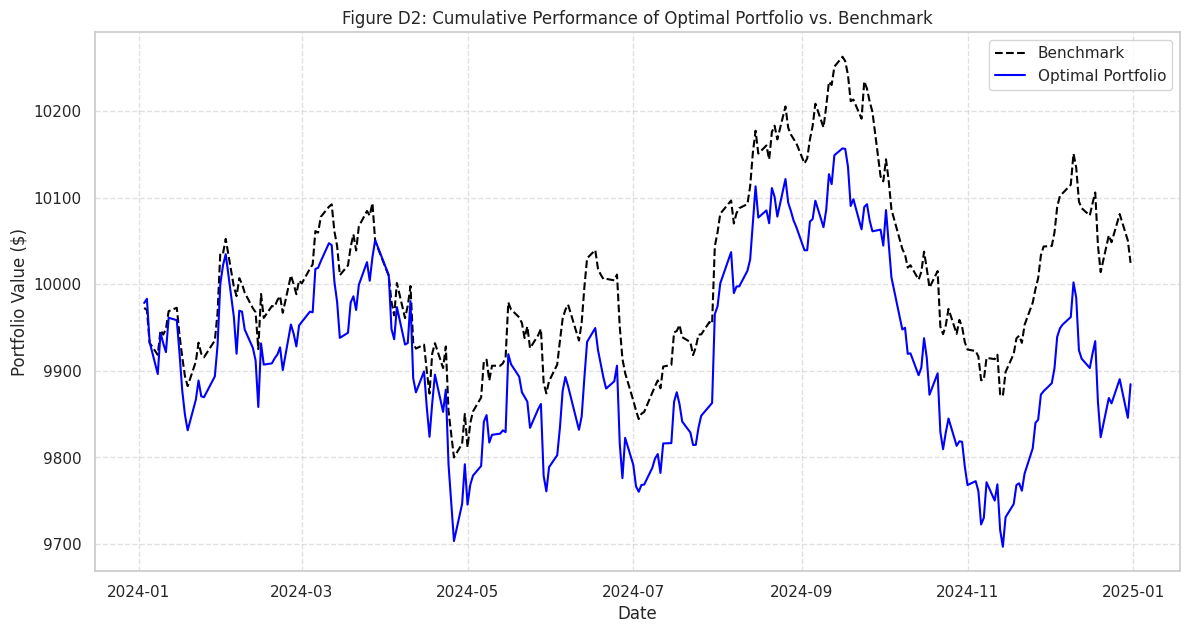

In [ ]:
# --- Step 6: Final Optimisation and Analysis (Corrected) ---
from scipy.optimize import minimize

print("\n--- Step 4: Running Final Optimization on Candidate Pool ---")

# Prepare inputs from the candidate pool
# Assumes df_candidate_pool and benchmark_returns_series are available from previous steps.
candidate_returns_matrix = df_candidate_pool.drop(columns=['RIC/ISIN', 'Duration', 'Bond Name', 'Correlation']).T.values.astype(float)
candidate_durations_vector = df_candidate_pool['Duration'].values
candidate_rics = df_candidate_pool['RIC/ISIN'].tolist()

def tracking_error_objective(weights, bond_returns, benchmark_returns):
    """Calculates the tracking error for a given set of portfolio weights."""
    portfolio_return = np.dot(bond_returns, weights)
    excess_return = portfolio_return - benchmark_returns
    return np.std(excess_return)

# Define a maximum weight for any single bond to enforce diversification
max_single_weight = 0.35 # No single bond can have more than 35% of the portfolio

# Define constraints and bounds for the final problem
constraints_final = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},              # Sum of weights = 1
    {'type': 'eq', 'fun': lambda w: np.dot(w, candidate_durations_vector) - 6.0} # Duration = 6.0
]
bounds_final = [(0, max_single_weight)] * len(candidate_rics)
initial_weights_final = np.ones(len(candidate_rics)) / len(candidate_rics)

# Run the final optimization
final_solution = minimize(
    tracking_error_objective,
    initial_weights_final,
    args=(candidate_returns_matrix, benchmark_returns_series.values),
    method='SLSQP',
    bounds=bounds_final,
    constraints=constraints_final,
    options={'maxiter': 2000, 'ftol': 1e-10}
)

# --- Analysis and Visualization of the Final Portfolio ---
if final_solution.success:
    # --- FIX: Use the correct solution variable ---
    final_weights = final_solution.x

    # Create the final portfolio composition table
    df_final_portfolio = pd.DataFrame({
        'RIC/ISIN': candidate_rics,
        'Optimal Weight': final_weights,
        'Duration': candidate_durations_vector
    }).merge(df_master[['RIC/ISIN', 'Bond Name']], on='RIC/ISIN', how='left')

    # Filter for bonds with meaningful weights to display the final portfolio
    df_final_display = df_final_portfolio[df_final_portfolio['Optimal Weight'] > 0.0001].sort_values(by='Optimal Weight', ascending=False)

    print("\nTable D5: Final Optimal Diversified Immunised Portfolio")
    display(df_final_display[['Bond Name', 'Optimal Weight', 'Duration']].round(4))

    # --- Verification ---
    final_portfolio_duration = np.dot(final_weights, candidate_durations_vector)
    final_tracking_error_annualised = final_solution.fun * np.sqrt(252)

    print("\nVerification of Final Portfolio:")
    print(f"Number of bonds in portfolio: {len(df_final_display)}")
    print(f"Portfolio Duration: {final_portfolio_duration:.4f} years")
    print(f"Annualised Tracking Error: {final_tracking_error_annualised*10000:.2f} bps")

    # --- Figure D2: Performance Plot ---
    final_portfolio_returns = np.dot(candidate_returns_matrix, final_weights)

    df_plot_final = pd.DataFrame({
        'Benchmark': benchmark_returns_series.values,
        'Optimal Portfolio': final_portfolio_returns
    }, index=benchmark_returns_series.index)

    cumulative_plot_final = 10000 * np.exp(df_plot_final.cumsum())

    plt.figure(figsize=(14, 7))
    plt.plot(cumulative_plot_final.index, cumulative_plot_final['Benchmark'], label='Benchmark', color='black', linestyle='--')
    plt.plot(cumulative_plot_final.index, cumulative_plot_final['Optimal Portfolio'], label='Optimal Portfolio', color='blue', linewidth=1.5)
    plt.title('Figure D2: Cumulative Performance of Optimal Portfolio vs. Benchmark')
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print(f"\nFinal optimization failed: {final_solution.message}")

#### **Tracking‐Error Optimization (Task D.6 rev.2)**
This section solves for the fully‐invested portfolio of all available bonds that (1) matches a target Macaulay duration of 6 years, (2) limits any single bond to a 35% weight, and (3) minimizes the portfolio’s historical tracking error versus the benchmark. Finally, it displays the top six holdings by weight, verifies duration and annualized TE, and plots cumulative performance against the benchmark.

Table D5: Top 6 bonds of the optimal immunised portfolio


,Bond Name,Optimal Weight,Duration
12,NAB 5.230 20-DEC-2031 FRN MTN,0.1951,5.9173
33,AUGV 0.250 21-NOV-2025,0.1267,0.8889
44,AUGV 1.250 21-MAY-2032,0.1239,7.0265
42,AUGV 1.500 21-JUN-2031,0.1186,6.1598
50,AUGV 3.000 21-MAR-2047,0.1153,15.1281
2,ANZ 5.070 31-JAN-2028 MTN,0.0636,2.8361



Verification:
  Portfolio Duration           = 6.0000 years
  Annualized Tracking Error    = 157.27 bps


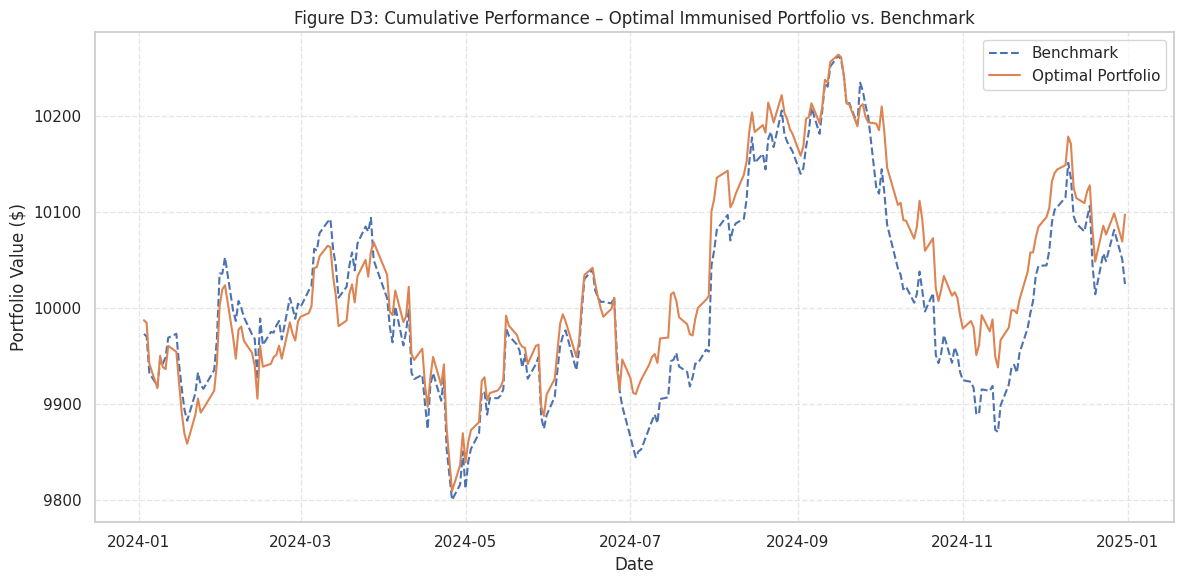

In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# — Assume df_master (complete bond universe), log_returns_complete, and benchmark_ric_identifier are already defined —

# 1) Prepare inputs for all bonds
#    Transpose returns so that each row is a bond RIC
log_returns_T  = log_returns_complete.T.reset_index().rename(columns={'index':'RIC/ISIN'})
#    Extract the benchmark return series
benchmark_row  = log_returns_T[log_returns_T['RIC/ISIN'] == benchmark_ric_identifier]
benchmark      = benchmark_row.iloc[0, 1:].astype(float)

#    Build a DataFrame of all non-benchmark bonds + their durations and names
bond_returns_T = log_returns_T[log_returns_T['RIC/ISIN'] != benchmark_ric_identifier]
df_all         = bond_returns_T.merge(
    df_master[['RIC/ISIN','Duration','Bond Name']],
    on='RIC/ISIN',
    how='inner'
)

#    Create the returns matrix and duration vector
returns_matrix = df_all.drop(columns=['RIC/ISIN','Duration','Bond Name']).T.values
durations_vec  = df_all['Duration'].values
rics_all       = df_all['RIC/ISIN'].tolist()

# 2) Define the tracking-error objective function
def te_obj(weights, returns, bench):
    """
    Compute portfolio returns, subtract benchmark,
    and return the standard deviation of the excess returns.
    """
    portfolio_returns  = returns.dot(weights)
    excess_returns     = portfolio_returns - bench.values
    return np.std(excess_returns)

# 3) Set up constraints and bounds
constraints = [
    { 'type':'eq', 'fun': lambda w: np.sum(w) - 1.0 },                # full investment
    { 'type':'eq', 'fun': lambda w: np.dot(w, durations_vec) - 6.0 } # duration == 6
]
bounds     = [(0.0, 0.35) for _ in rics_all]                         # max 35% per bond
initial_w  = np.ones(len(rics_all)) / len(rics_all)                  # equal‐weight start

# 4) Run the optimization
result = minimize(
    te_obj, initial_w,
    args=(returns_matrix, benchmark),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter':2000, 'ftol':1e-10}
)

# 5) Output results if successful
if result.success:
    w_opt = result.x

    # Build final portfolio table: show top 6 holdings by weight
    df_final = (
        pd.DataFrame({
            'RIC/ISIN':       rics_all,
            'Optimal Weight': w_opt,
            'Duration':       durations_vec
        })
        .merge(df_master[['RIC/ISIN','Bond Name']], on='RIC/ISIN', how='left')
        .query('`Optimal Weight` > 1e-4')
        .sort_values('Optimal Weight', ascending=False)
        .head(6)
        .round(4)
    )
    print("Table D5: Top 6 bonds of the optimal immunised portfolio")
    display(df_final[['Bond Name','Optimal Weight','Duration']])

    # Verify portfolio duration and annualized tracking error
    portfolio_duration     = np.dot(w_opt, durations_vec)
    annualized_te_in_bps   = result.fun * np.sqrt(252) * 1e4
    print("\nVerification:")
    print(f"  Portfolio Duration           = {portfolio_duration:.4f} years")
    print(f"  Annualized Tracking Error    = {annualized_te_in_bps:.2f} bps")

    # 6) Plot cumulative performance
    portfolio_returns = returns_matrix.dot(w_opt)
    performance_df    = pd.DataFrame({
        'Benchmark': benchmark.values,
        'Portfolio': portfolio_returns
    }, index=benchmark.index)
    cumulative_df     = 10000 * np.exp(performance_df.cumsum())

    plt.figure(figsize=(12,6))
    plt.plot(cumulative_df.index, cumulative_df['Benchmark'], '--', label='Benchmark')
    plt.plot(cumulative_df.index, cumulative_df['Portfolio'],  '-',  label='Optimal Portfolio')
    plt.title('Figure D3: Cumulative Performance – Optimal Immunised Portfolio vs. Benchmark')
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

else:
    raise RuntimeError(f"Optimization failed: {result.message}")


#### **Task D.7: Sortino-Ratio Optimization with Duration = 6 Years**

In this section, we perform a Sortino-ratio optimization over the full bond universe.

Objective: Maximize the Sortino ratio (assuming a minimum acceptable return of 0%).

Constraints:

- Fully invested (weights sum to 1)

- Target portfolio Macaulay duration of 6 years

- No single bond > 35% weight

Output: Top 6 holdings by weight, verification of duration and Sortino ratio, and a plot of cumulative performance versus the benchmark.

Table D6: Top 6 Bonds in the Sortino-Optimized Portfolio


,Bond Name,Optimal Weight,Duration
12,NAB 5.230 20-DEC-2031 FRN MTN,0.3500,5.9173
30,BOQ 1.400 06-MAY-2026 MTN,0.2779,1.3374
15,WBC 2.350 27-FEB-2040 MTN,0.1782,12.0566
27,GPTX 2.849 20-FEB-2032 '31 MTN,0.1500,6.3569
13,NAB 4.100 09-MAR-2038 MTN,0.0221,9.7682
4,ANZ 3.400 20-DEC-2039,0.0219,10.9612



Verification:
  Portfolio Duration = 6.0000 years
  Sortino Ratio      = 0.1296


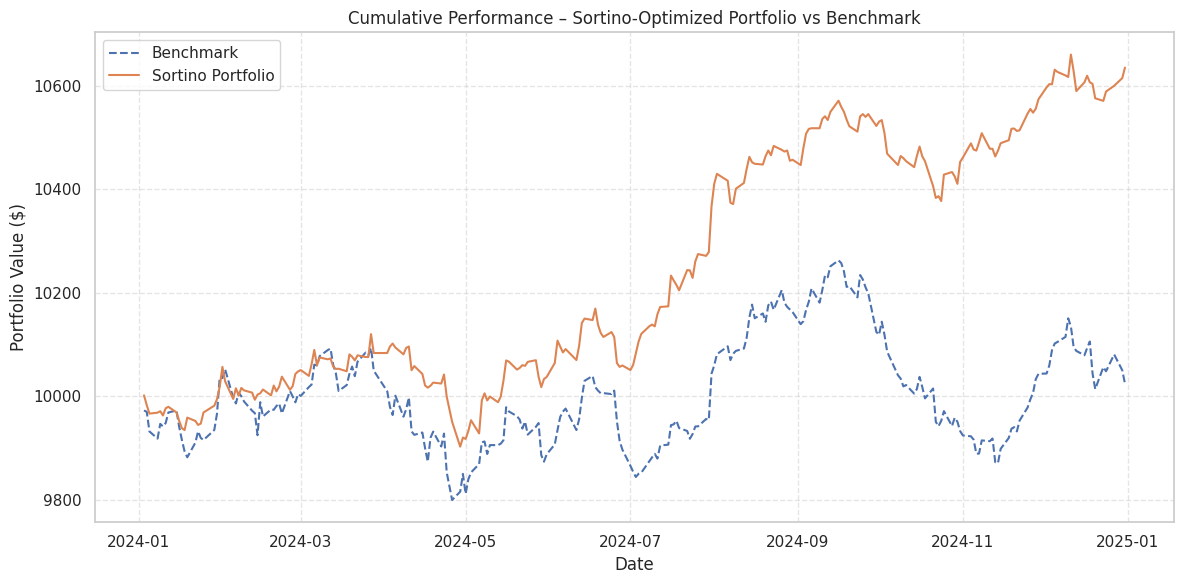

In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume returns_matrix, durations_vec, rics_all, df_master, and benchmark_returns_series are already defined

# 1) Define the objective: negative Sortino ratio for minimization (minimum acceptable return = 0)
def sortino_objective(weights, returns, mar=0.0):
    """
    Calculate the negative Sortino ratio:
      Sortino = (mean(portfolio) - MAR) / downside_deviation
    """
    portfolio_returns = returns.dot(weights)
    mean_return       = np.mean(portfolio_returns)
    # Only returns below MAR contribute to downside deviation
    downside_diff     = portfolio_returns[portfolio_returns < mar] - mar
    downside_dev      = np.sqrt(np.mean(downside_diff**2)) if len(downside_diff) > 0 else 1e-8
    # Return negative for minimizer
    return - (mean_return - mar) / downside_dev

# 2) Set constraints and bounds
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},             # fully invested
    {'type': 'eq', 'fun': lambda w: np.dot(w, durations_vec) - 6.0}  # duration == 6
]
bounds     = [(0.0, 0.35)] * len(rics_all)                       # max 35% per bond
initial_w  = np.ones(len(rics_all)) / len(rics_all)              # equal-weight start

# 3) Run the optimization
result = minimize(
    sortino_objective,
    initial_w,
    args=(returns_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 2000, 'ftol': 1e-10}
)

# 4) Display results if successful
if result.success:
    optimal_weights = result.x

    # Build a table of the top 6 holdings by weight
    df_optimal = (
        pd.DataFrame({
            'RIC/ISIN':       rics_all,
            'Optimal Weight': optimal_weights,
            'Duration':       durations_vec
        })
        .merge(df_master[['RIC/ISIN','Bond Name']], on='RIC/ISIN', how='left')
        .query('`Optimal Weight` > 1e-4')
        .sort_values('Optimal Weight', ascending=False)
        .head(6)
        .round(4)
    )
    print("Table D6: Top 6 Bonds in the Sortino-Optimized Portfolio")
    display(df_optimal[['Bond Name','Optimal Weight','Duration']])

    # Verify portfolio metrics
    portfolio_returns   = returns_matrix.dot(optimal_weights)
    mean_return         = np.mean(portfolio_returns)
    downside_returns    = portfolio_returns[portfolio_returns < 0]
    downside_dev        = np.sqrt(np.mean(downside_returns**2)) if len(downside_returns) > 0 else np.nan
    sortino_ratio       = mean_return / downside_dev
    portfolio_duration  = np.dot(optimal_weights, durations_vec)

    print(f"\nVerification:")
    print(f"  Portfolio Duration = {portfolio_duration:.4f} years")
    print(f"  Sortino Ratio      = {sortino_ratio:.4f}")

    # 5) Plot cumulative performance
    performance_df = pd.DataFrame({
        'Benchmark':          benchmark_returns_series.values,
        'Sortino Portfolio':  portfolio_returns
    }, index=benchmark_returns_series.index)
    cumulative_values = 10000 * np.exp(performance_df.cumsum())

    plt.figure(figsize=(12,6))
    plt.plot(cumulative_values.index, cumulative_values['Benchmark'],         '--', label='Benchmark')
    plt.plot(cumulative_values.index, cumulative_values['Sortino Portfolio'], '-',  label='Sortino Portfolio')
    plt.title('Cumulative Performance – Sortino-Optimized Portfolio vs Benchmark')
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

else:
    raise RuntimeError(f"Sortino optimization failed: {result.message}")
